# Microbiome analysis for simulated data

The notebook reproduces the experiments on the purely simulated data in the paper [__A causal view on compositional data__](https://arxiv.org/abs/2106.11234) by E. Ailer, C. L. Müller and N. Kilbertus.

For the semi-synthetic setup, we refer to the other two notebooks available in the folder.


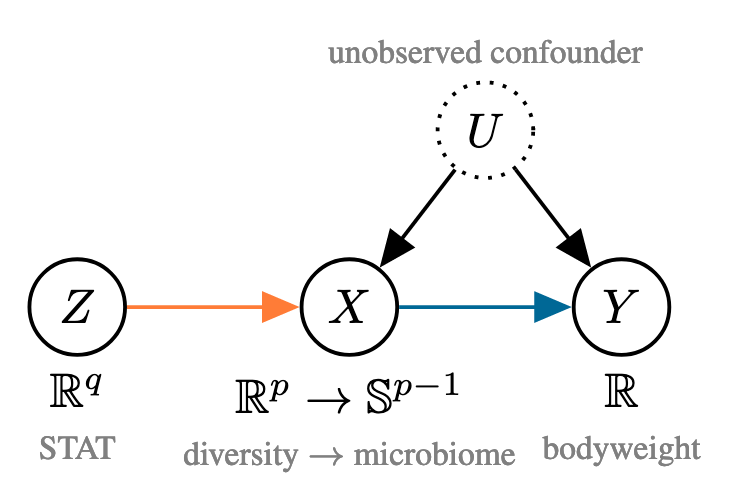



<div class="alert alert-block alert-info">
<b>Note:</b>    
    
We chose a notebook format so the input we generated can be replaced, changed and customized to anyone's liking. The methods can be used separately and they can be applied in different compositional contexts.


 
</div>


# Loading of libraries

In [6]:
# STANDARD LIBRARIES
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../src"))
import jax
import jax.numpy as np
import numpy as onp
import skbio.stats.composition as cmp
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import statsmodels.api as sm
from datetime import datetime
from types import SimpleNamespace


# SPECIFIC FUNCTION FILES
# data simulation
from parameter_settings import simulate_data, return_parameter_setting
from simulate_data_fct import sim_IV_ilr_linear, sim_IV_ilr_nonlinear

# methods function file
from helper_fct import diversity
from run_methods_all import run_methods_confidence_interval, run_methods_all, run_diversity_estimation_methods

# plotting functionalities
from plot_fct import update_layout, update_layout_px, colours, plot_ilr_X_vs_Y, plot_mse_results, plot_beta_results, plot_diversity_methods


# Generation of  Microbiome Dataset

Apart from a real dataset (see other notebooks in the folder), we evaluated our methods on simulated datasets where we have a ground truth available. The functions `return_parameter_setting` and `simulate_data` will reproduce the different setups, including the key that was used in the simulations.


If you have own data available you can skip this step and replace the variables:

- `Z_sim` _instrument matrix_, i.e. antibiotic treatment etc.
- `X_sim` _compositional matrix_, i.e. microbiome data
- `Y_sim` _output matrix_, i.e. weight
- `confounder` _confounding term_
- `X_star` _compositional interventional data_
- `Y_star` _output matrix from interventional data without confounding_


If no other data is available, the box below indicates the different setups and how to get the parameter settings. We unpack the parameter settings in a separate namespace. If you want to make changes to the setup, a simple overwriting of the original parameters is enough, i.e. 

```python
# overwriting from betaT = np.array([6, 4])
param.betaT = np.array([6, 5])

```


<div class="alert alert-block alert-warning">
<b>Note:</b>    
    
In this section we chose from the different setups shown in the paper. We refer to the python file for the individual generation of the data setup.

Here, it is possible to chose between
    
- __Linear, 3 dimensional setup with weak instruments :__ 
       "p3", "linear", "weak"
- __Linear, 3 dimensional setup with strong instruments :__  
       "p3", "linear", "medium"
-__Non-linear, 3 dimensional setup with weak instruments :__  
       "p3", "nonlinear", "strong"
- __Negative Binomial first stage simulation, 20 dimensional setup with strong instruments :__  
       "p20", "negbinom", "unknown"
- __Linear, 20 dimensional setup with strong instruments :__  
       "p20", "linear", "unknown"

 
</div>

## Get parameter settings




In [8]:
# set options for data generation
strDim = "p20"
strRel = "negbinom"
strInst = "unknown"

# get parameter setting which is used in the paper
dictReturn = return_parameter_setting(strDim, strRel, strInst)

# generate namespace for parameters
param = SimpleNamespace(**dictReturn)

# print the parameter setting
print(strDim, strRel, strInst)
param

p20 negbinom unknown


namespace(strDim='p20',
          strRel='negbinom',
          strInst='unknown',
          n=500,
          p=30,
          num_inst=20,
          c_X=2,
          alpha0=DeviceArray([1, 1, 2, 1, 4, 4, 2, 1, 4, 4, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2,
                              2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1], dtype=int32),
          alphaT=DeviceArray([[ 0,  0,  0,  0, 10,  0, 10,  0, 10,  0, 10,  0,  0, 10,  0,
                                0, 10,  0,  0,  0,  0, 10,  0,  0, 10,  0,  0, 10, 10,  0],
                              [ 0,  0,  0, 10, 10, 10, 10, 10,  0,  0, 10,  0,  0,  0,  0,
                                0,  0,  0,  0,  0,  0,  0, 10, 10,  0,  0,  0,  0, 10,  0],
                              [10, 10,  0, 10,  0, 10, 10,  0, 10,  0,  0,  0,  0,  0,  0,
                               10, 10,  0, 10,  0,  0,  0,  0, 10, 10,  0,  0,  0, 10,  0],
                              [ 0,  0,  0,  0, 10, 10,  0,  0,  0,  0, 10, 10, 10,  0, 10,
                            

## Simulate data from the parameter settings

In [9]:
confounder, Z_sim, X_sim, Y_sim, X_star, Y_star = simulate_data(dictReturn)

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/skbio/stats/composition.py:464: RuntimeWarning: divide by zero encountered in log
  lmat = np.log(mat)
/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/skbio/stats/composition.py:466: RuntimeWarning: invalid value encountered in subtract
  return (lmat - gm).squeeze()


# Data Visualization

This section is for reproducing the visualizations of the data in the paper.    

We remind that the ternary plots are only feasible for $p=3$.     
The barplot of the microbiome samples is cut off at $6$ to ensure better readability. This, however, can be changed easily.


## Barplot for microbiome visualization $X$

In [22]:
cut_off = 6

if param.p==3:
    fig = px.bar(pd.DataFrame(X_sim[:100, :], columns=["Microbe 1", "Microbe 2", "Microbe 3"]))
    fig = update_layout_px(fig)
    fig.update_xaxes(title="Sample number")
    fig.update_yaxes(title="Percentage of microbiota in sample")
    fig.show()
    
if param.p > cut_off:
    X_plot = np.hstack([X_sim[:, :cut_off], X_sim[:, cut_off:].sum(axis=1).T[..., np.newaxis]])
    fig = px.bar(pd.DataFrame(X_plot[:100, :], columns=["Microbe "+str(i) for i in range(X_plot.shape[1]-1)] + ["Other"]))
    fig = update_layout_px(fig)
    fig.update_xaxes(title="Sample number")
    fig.update_yaxes(title="Percentage of microbiota in sample")
    fig.show()

## Ternary plot for microbiome visualization $X$

In [19]:
# ternary plot for first instrument
if param.p == 3:
    df = pd.DataFrame(X_sim, columns=["Microbe 1", "Microbe 2", "Microbe 3"])
    fig = px.scatter_ternary(df, a='Microbe 1', 
                             b='Microbe 2', 
                             c='Microbe 3',
                             color=Z_sim[:, 0].squeeze(),
                            labels={"color": "Instrument value"})

    fig = update_layout_px(fig)
    fig.show()

In [20]:
# ternary plot for second instrument
if param.p == 3:
    fig = px.scatter_ternary(df, a='Microbe 1', 
                             b='Microbe 2', 
                             c='Microbe 3',
                             color=Z_sim[:, 1].squeeze()
                            ,
                            labels={"color": "Instrument value"})

    fig = update_layout_px(fig)
    fig.show()

## ilr-coordinate plot

ilr-coordinates can be transformed back and forth to the compositional data space by the _Gram Schmidt Basis_ (for example). The transformation function is included in the compositional package of sklearn


In [23]:
# generate ilr coordinates
X_sim_ilr = cmp.ilr(X_sim)
X_star_ilr = cmp.ilr(X_star)

In [21]:
fig = plot_ilr_X_vs_Y(X_sim_ilr, X_star_ilr, Y_sim, Y_star)
fig.update_layout(width=2000, height=500)
fig.show()

# Causal effect of diversity


As the first motivation for looking into compositional data is coming from the---sometimes---misleading diversity measure summary statistic, we include the computation here as well. 

<div class="alert alert-block alert-danger">
<b>Note:</b>    

In this section we look at the plug-in estimate instead of the finer estimation as in[DivNet](https://github.com/adw96/DivNet) and [breakaway](https://github.com/adw96/breakaway) by Amy Willis because of lacking a simulation for the phylogenetic tree.

 
</div>

In [24]:
div_shannon = diversity(X_sim, "shannon")
div_simpson = diversity(X_sim, "simpson")

In [25]:
# Shannon Estimation
x, y, ytrue, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results = run_diversity_estimation_methods(
    Z_sim, div_shannon, Y_sim, Ytrue=Y_star, methods=["OLS", "2SLS", "KIV"])

fig = plot_diversity_methods(x, y, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results, ytrue)
fig.show()

INFO:absl:Setup matrices...


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9489
Date:                 Di, 13 Jul 2021   Prob (F-statistic):              0.525
Time:                        16:49:42   Log-Likelihood:                -699.76
No. Observations:                 500   AIC:                             1442.
Df Residuals:                     479   BIC:                             1530.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5711      0.436     -1.309      0.1

INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [3.86286207]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-4.84792038]...
INFO:absl:Predict treatment effect...


In [26]:
# Simpson Estimation
x, y, ytrue, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results = run_diversity_estimation_methods(
    Z_sim, div_simpson, Y_sim, Ytrue=Y_star, methods=["OLS", "2SLS", "KIV"])

plot_diversity_methods(x, y, xstar, xstar_bound, ystar_ols, ystar_2sls, ystar_kiv, results, ytrue)
fig.show()

INFO:absl:Setup matrices...
INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [3.74709732]...
INFO:absl:Optimize xi...


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.070
Date:                 Di, 13 Jul 2021   Prob (F-statistic):              0.378
Time:                        16:49:48   Log-Likelihood:                -698.55
No. Observations:                 500   AIC:                             1439.
Df Residuals:                     479   BIC:                             1528.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5796      0.435     -1.332      0.1

INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-7.05722519]...
INFO:absl:Predict treatment effect...


# Causal effect of compositional data

In some cases, the summary statistic of __diversity__ can be misleading. In any case, however, it is sensible to look into the whole microbiome to get a more detailed picture of the causal effects.


This section will run all approaches of the paper in one go. Necessary are the ground truth values `X_star`, `Y_star`, `betaT` as well as the simulated data `Z_sim`, `X_sim` and `Y_sim`. 

The following section then is dedicated to the computation of confidence intervals for the causal effect as shown in the paper.

## Computation of F-Statistic


<div class="alert alert-block alert-info">
<b>Disclaimer:</b>    

For $p > 2$ the F-Statistic of the first stage serves only as a very slight relative indication of instrument strength. 

 
</div>


In [29]:
# Compute F-Statistics 
ZZ_sim = onp.array(sm.add_constant(Z_sim))
alphahat = np.linalg.inv(ZZ_sim.T@ZZ_sim)@ZZ_sim.T@X_sim_ilr
MSM = np.sum(((ZZ_sim@alphahat - np.mean(X_sim_ilr, axis=0))**2), axis=0)/(param.num_inst)
MSE = np.sum(((ZZ_sim@alphahat - X_sim_ilr)**2), axis=0)/(param.n-param.num_inst)
F = MSM / MSE
F

DeviceArray([ 3.1095831 ,  4.683362  ,  0.84865195,  1.4754441 ,
              1.219881  ,  1.2485825 ,  2.3793278 ,  2.4861884 ,
              2.9436872 ,  1.5712388 ,  3.925723  ,  5.3248014 ,
              1.550153  , 10.005062  ,  1.4749167 ,  2.0349565 ,
              0.79375106,  1.2641897 ,  1.2268661 ,  1.3724124 ,
              0.82611763,  1.4274231 ,  1.3424872 ,  1.0051297 ,
              0.87191564,  1.1115983 ,  0.83043724,  1.0209956 ,
              0.81902   ], dtype=float32)

## Causal effect estimation on higher dimensional data

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY Second Stage - ILR Regression >>>>>>>>>>>>>>>>>>>>>>>>>>>
True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-4.070e+00 -4.600e-01  3.410e+00  2.260e+00  1.700e-01  5.320e+00
 -1.890e+00  3.080e+00  6.650e+00  2.590e+00 -7.000e-02  3.400e+00
  1.122e+01  8.000e-01 -9.000e-01  4.000e-01  1.400e-01 -9.000e-02
  5.400e-01 -1.700e-01  5.000e-02  2.200e-01  2.300e-01 -1.000e-02
 -2.300e-01  2.000e-02  0.000e+00 -4.200e-01 -6.000e-02]
Estimated Beta: [ 1.470e+00  7.230e+00  4.910e+00  6.000e-01  1.030e+00  2.860e+00
 -2.730e+00  4.220e+00 -8.100e-01 -4.920e+00 -1.330e+00  1.210e+00
 -2.400e+00 -1.077e+01 -7.900e-01  9.200e-01 -3.700e-01 -1.200e-01
  1.000e-01 -5.400e-01  1.600e-01 -6.000e-02 -2.300e-01 -2.500e-01
 -2.000e-02  2.100e-01 -4.000e-02 -1.000e-02  4.100e

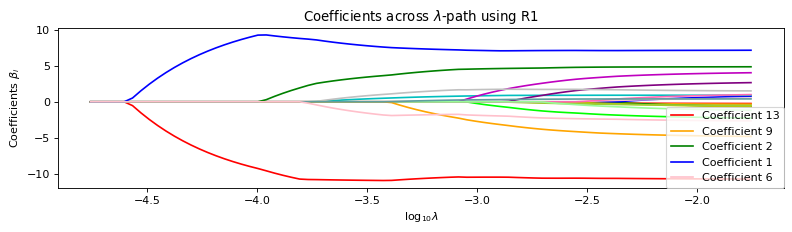

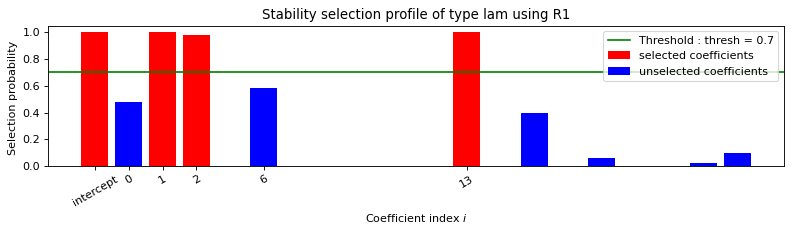

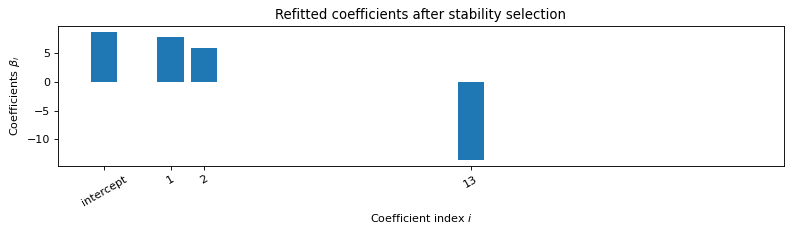


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    
   Running time :  0.049s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     7.65   5.85   0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.   -13.5    0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]
Error: 3620.97

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


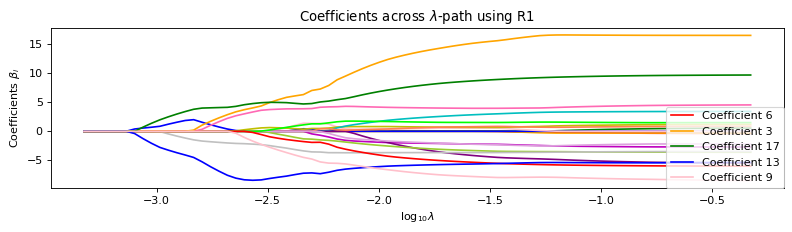

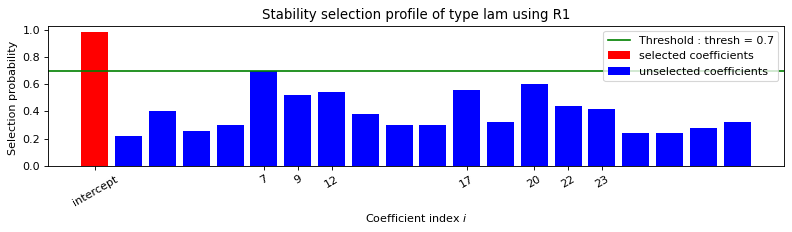

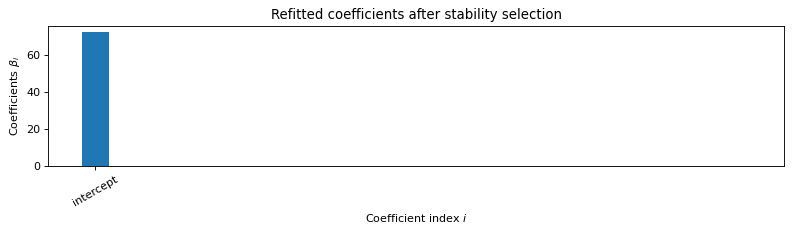


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    
   Running time :  0.123s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Error: 877.05

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


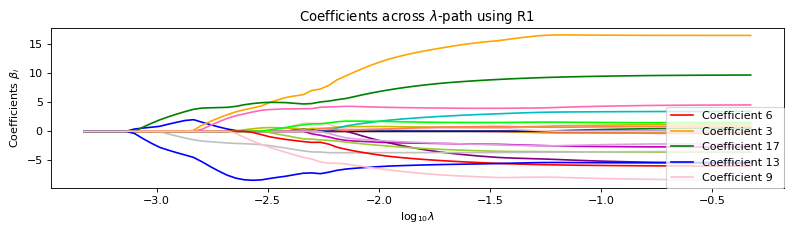

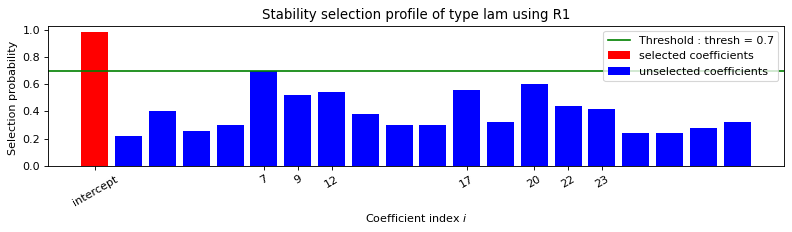

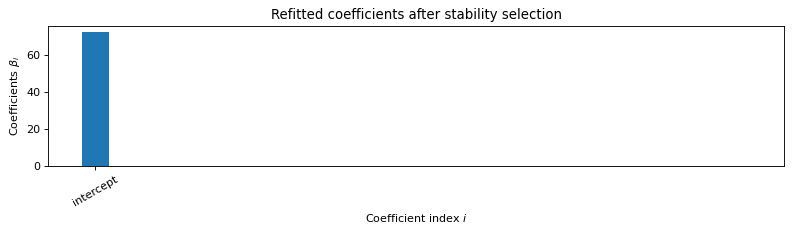

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    
   Running time :  0.126s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Error: 877.05

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.89018503]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 872.21

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3626.2

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2558.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>
                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -7.181
Model:                         IV2SLS   Adj. R-squared:                 -7.686
Method:                     Two Stage   F-statistic:                  -0.06653
                        Least Squares   Prob (F-statistic):              

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 12

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



In [30]:
lambda_dirichlet= np.array([0.1, 1, 2, 5, 10])
logcontrast_threshold = 0.7
max_iter = 5

mse_all, beta_all, title_all, mse_large = run_methods_all(Z_sim, X_sim, Y_sim, X_star, Y_star, param.betaT,
                        lambda_dirichlet, max_iter, logcontrast_threshold)

In [32]:
# print results
pd.DataFrame(zip(title_all, mse_all, beta_all), columns=["Method", "OOS MSE", "Beta values"])

Method    OOS MSE  \
0  ONLY Second ILR  3628.0544   
1   ONLY Second LC   3620.973   
2           ILR+LC   877.0531   
3           ALR+LC   877.0531   
4              KIV   872.2101   
5  ONLY Second KIV  3626.1978   
6    Kernel+Kernel  2558.5762   
7          ILR+ILR  13210.892   

                                         Beta values  
0  [-4.069297898954466, -0.45580503571605124, 3.4...  
1  [-5.412195, -1.6517725, 3.8982687, 3.019586, 2...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4                                               None  
5                                               None  
6                                               None  
7  [-1.5953531, -38.13065, 20.653603, 38.98572, -...

# Confidence Intervals for higher dimensional methods

The above only estimated for one sample from the dataset. To get a better overview, we need confidence bands on the OOS MSE and the $\beta$ values.

## Confidence intervals for causal effect estimation

**************************************************************************************************
*****************************************We are at 0 of 20***********************************************
**************************************************************************************************
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY Second Stage - ILR Regression >>>>>>>>>>>>>>>>>>>>>>>>>>>
True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-2.42 -2.01  2.83 -3.7  -2.82 -0.6  -2.    1.74  0.72  1.84  2.36  2.68
  5.98  0.13  4.58  3.54  4.89  1.77  2.47  0.46 -0.56  1.88  0.79  0.62
  0.77  6.15  1.67  2.19 11.12]
Estimated Beta: [ -0.16   3.26   4.02  -0.89   5.69   5.47   3.55   5.13   1.41   2.29
   1.05   0.34  -0.19  -3.82   1.8   -2.8   -2.01  -3.61  -0.68  -1.49
   0.44   1.46  -1.01

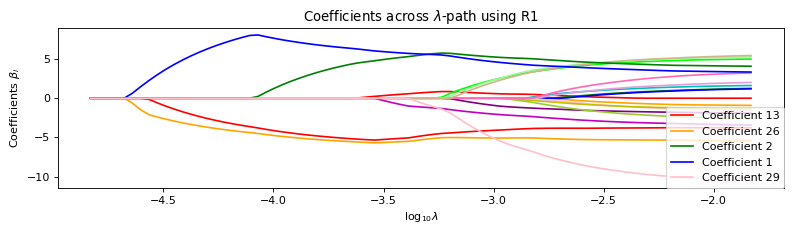

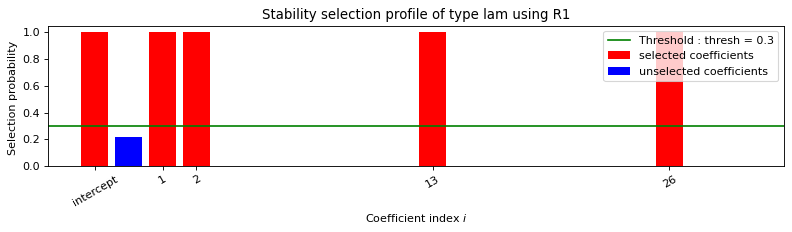

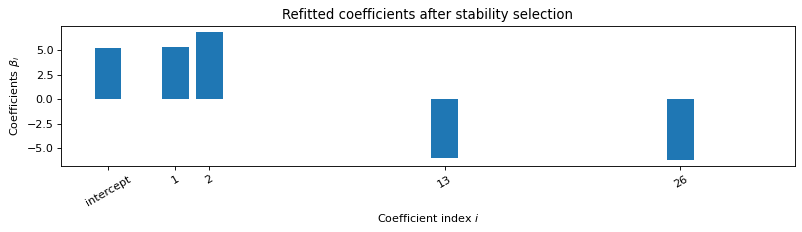


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.069s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.32  6.84  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -5.99  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -6.17  0.    0.    0.  ]
Error: 4127.07

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


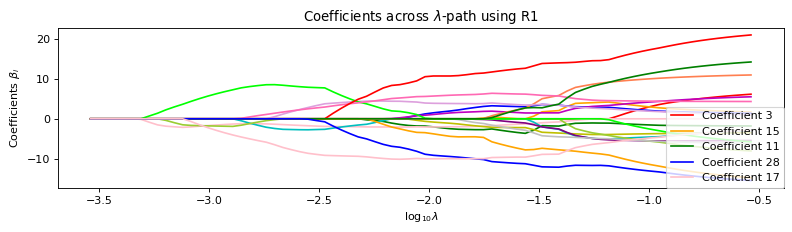

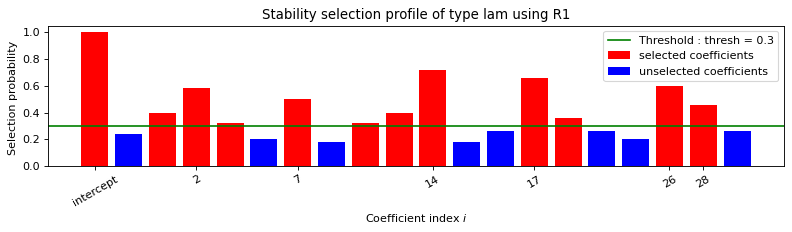

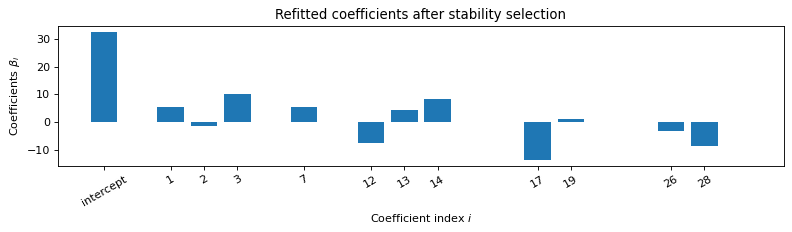


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    7    12    13    14    17    19    26    28    
   Running time :  0.141s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     5.58  -1.33  10.04   0.     0.     0.     5.38   0.     0.
   0.     0.    -7.7    4.23   8.28   0.     0.   -13.65   0.     1.08
   0.     0.     0.     0.     0.     0.    -3.14   0.    -8.79   0.  ]
Error: 3610.29

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


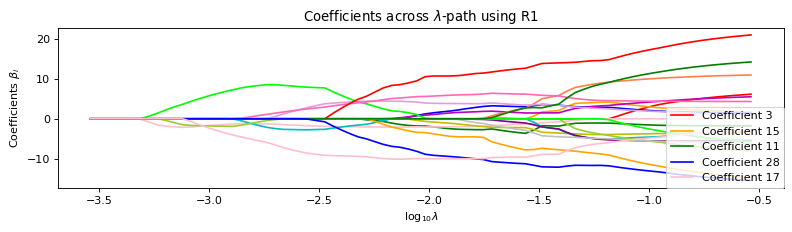

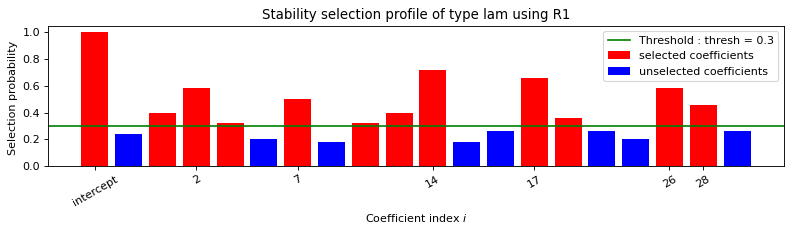

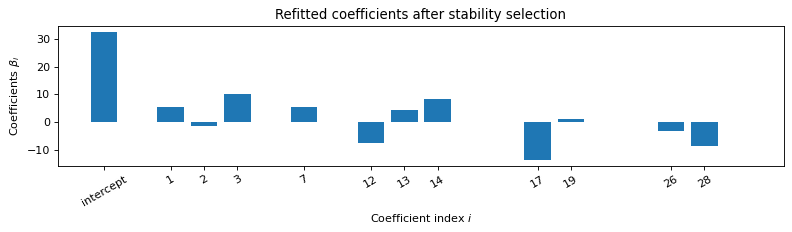

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    3    7    12    13    14    17    19    26    28    
   Running time :  0.132s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-3.95  3.36 -7.47  3.2   2.61  2.21 -3.13  2.32  2.07  1.88  1.71  8.97
 -3.19 -6.88  1.58  1.49 14.66  0.59 -0.49  0.58  0.55  0.53  0.51  0.49
  0.47  3.53  0.32  8.94  0.  ]
Error: 3610.29

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.57892031]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-2.99572192]...
INFO:absl:Predict treatment effect...


Error: 1012.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4195.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3865.82

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -32.191
Model:                         IV2SLS   Adj. R-squared:                -34.239
Method:                     Two Stage   F-statistic:                 2.958e-15
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:09:23                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.2029   1.19e+10   7.15e-09      1.0

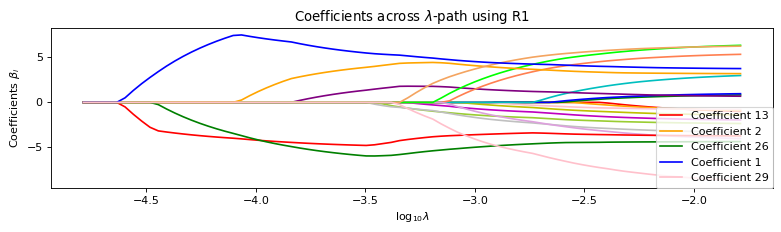

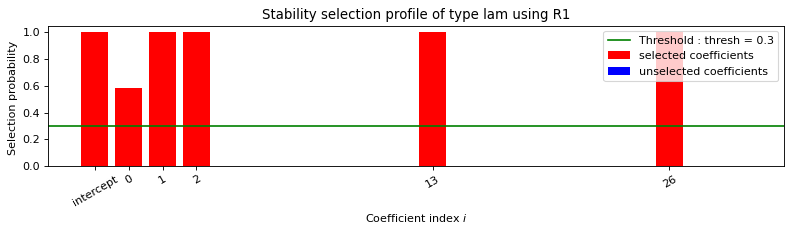

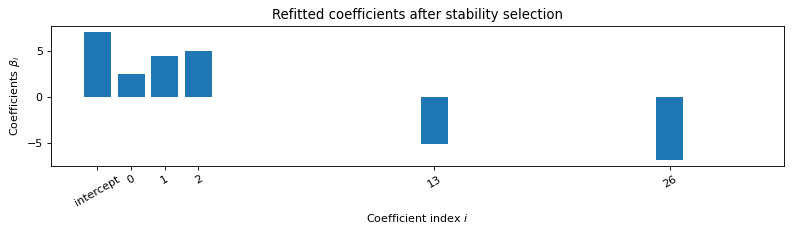


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.081s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.48  4.46  4.94  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -5.07  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -6.82  0.    0.    0.  ]
Error: 3665.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


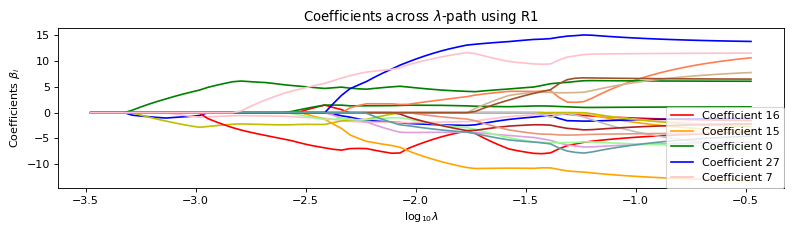

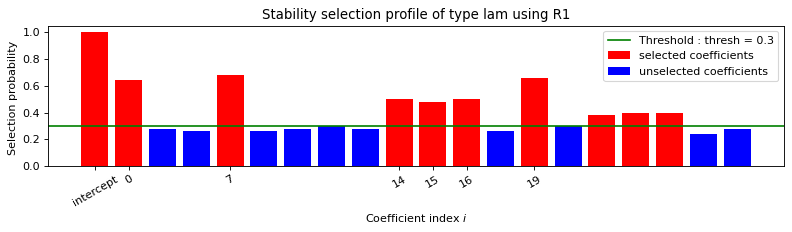

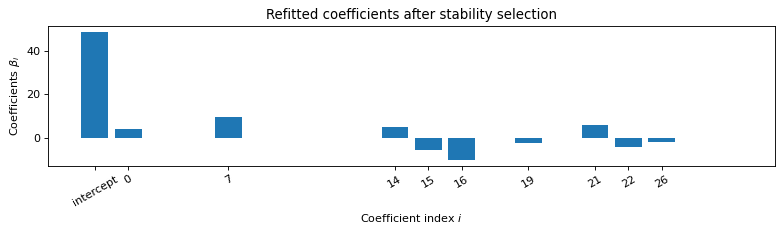


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.016s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    7    14    15    16    19    21    22    26    
   Running time :  0.168s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  4.19   0.     0.     0.     0.     0.     0.     9.29   0.     0.
   0.     0.     0.     0.     4.78  -5.67 -10.04   0.     0.    -2.25
   0.     5.87  -4.33   0.     0.     0.    -1.84   0.     0.     0.  ]
Error: 2384.38

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


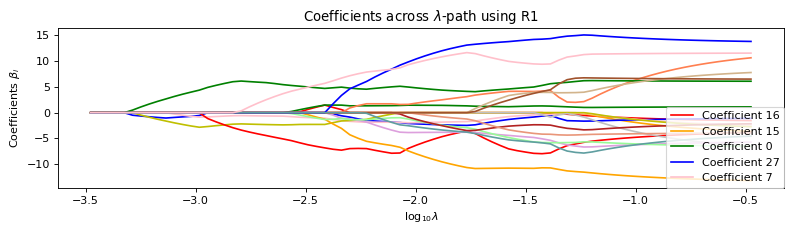

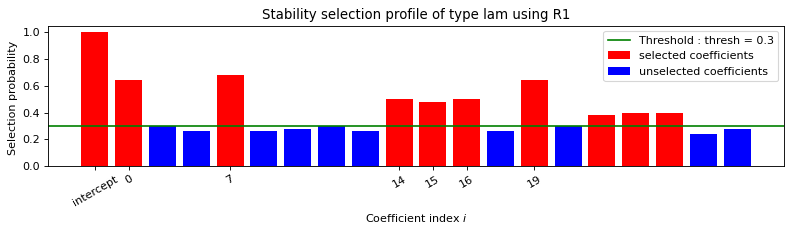

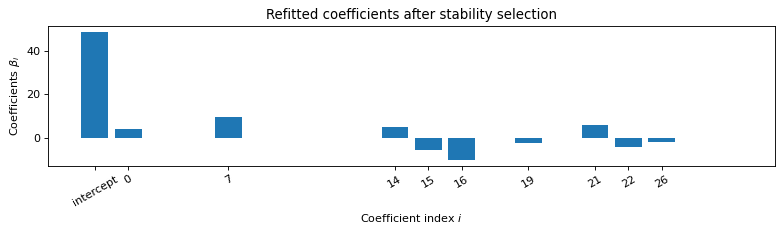

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    7    14    15    16    19    21    22    26    
   Running time :  0.155s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.960e+00  1.710e+00  1.210e+00  9.400e-01  7.600e-01  6.500e-01
 -8.130e+00  1.590e+00  1.420e+00  1.280e+00  1.170e+00  1.080e+00
  1.000e+00 -3.690e+00  6.670e+00  1.051e+01  1.500e-01  1.400e-01
  2.320e+00  1.000e-02 -5.720e+00  4.510e+00  8.000e-02  8.000e-02
  7.000e-02  1.880e+00  0.000e+00  0.000e+00  0.000e+00]
Error: 2384.38

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.05820499]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573227]...
INFO:absl:Predict treatment effect...


Error: 1138.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3603.99

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2147.84

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -70.869
Model:                         IV2SLS   Adj. R-squared:                -75.304
Method:                     Two Stage   F-statistic:                  -0.01254
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:11:28                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.1190   3.21e+08   -3.4e-07      1.0

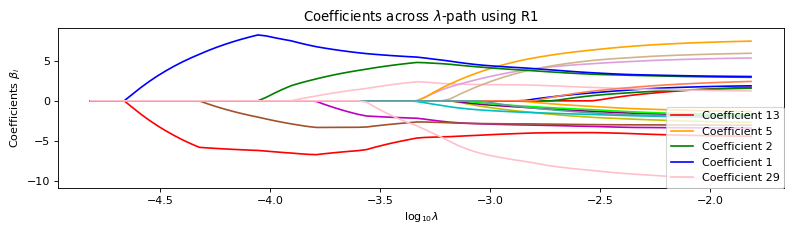

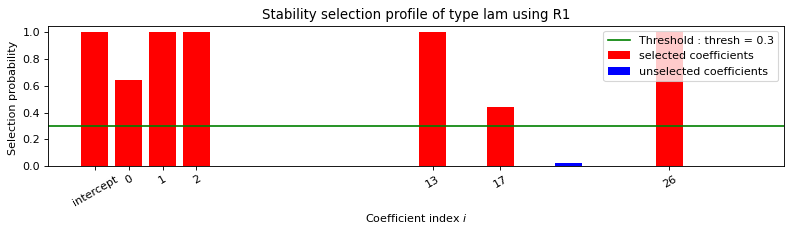

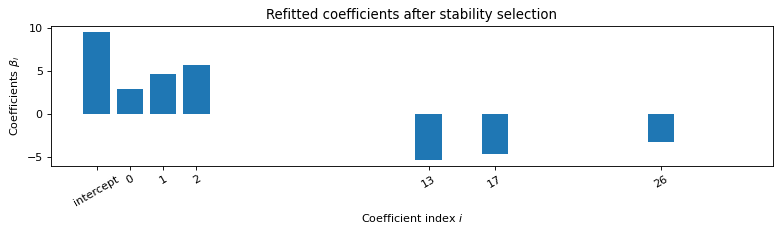


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.071s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.88  4.65  5.72  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -5.32  0.    0.    0.   -4.65  0.    0.    0.    0.    0.    0.
  0.    0.   -3.28  0.    0.    0.  ]
Error: 3557.65

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


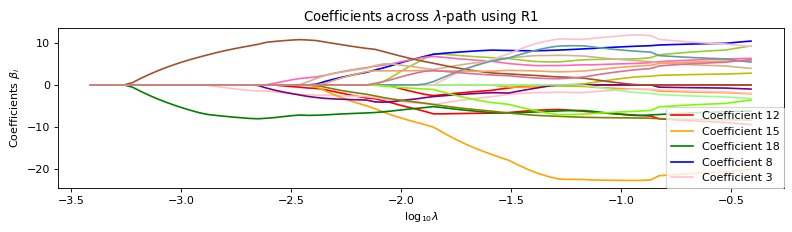

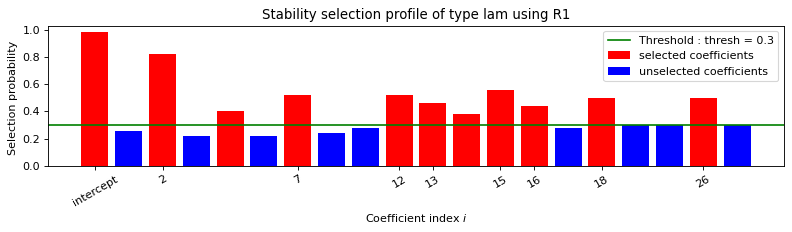

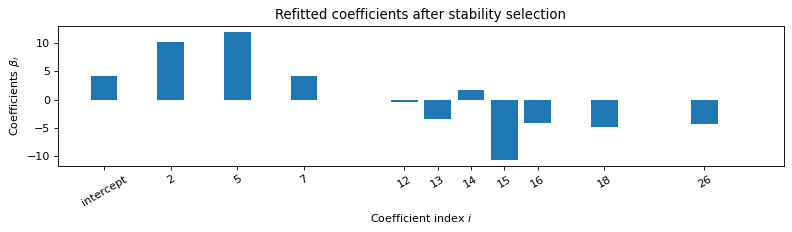


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    12    13    14    15    16    18    26    
   Running time :  0.146s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     0.    10.21   0.     0.    11.94   0.     4.15   0.     0.
   0.     0.    -0.38  -3.51   1.62 -10.63  -4.23   0.    -4.81   0.
   0.     0.     0.     0.     0.     0.    -4.38   0.     0.     0.  ]
Error: 3573.65

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


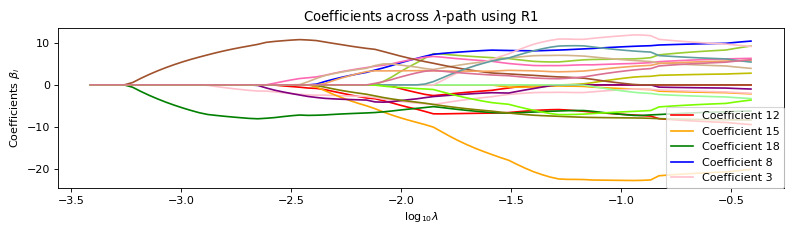

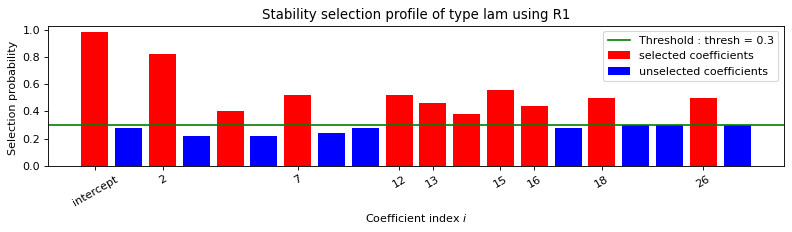

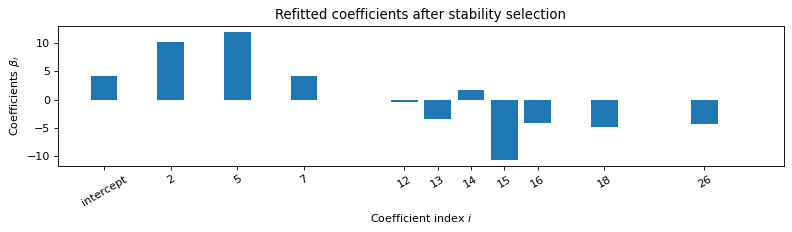

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    5    7    12    13    14    15    16    18    26    
   Running time :  0.148s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -8.34  2.95  2.28 -9.04  3.42 -0.92  3.1   2.77  2.51  2.29  2.47
  5.31 -0.02 11.84  4.92  0.53  5.18  0.22  0.21  0.2   0.19  0.19  0.18
  0.17  4.46  0.    0.    0.  ]
Error: 3573.64

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.05102835]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99572788]...
INFO:absl:Predict treatment effect...


Error: 957.32

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3718.14

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3285.66

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -13.975
Model:                         IV2SLS   Adj. R-squared:                -14.898
Method:                     Two Stage   F-statistic:                -0.0001480
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:13:36                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.0210        nan        nan        n

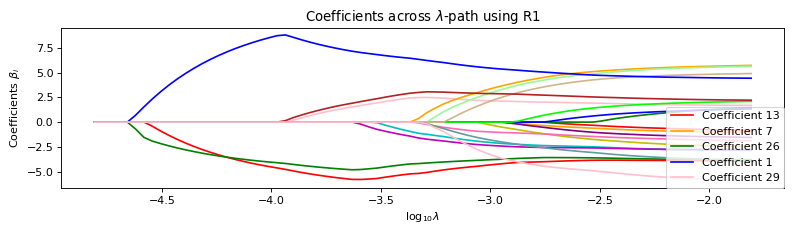

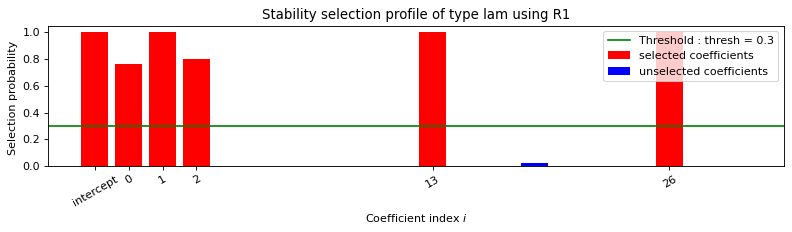

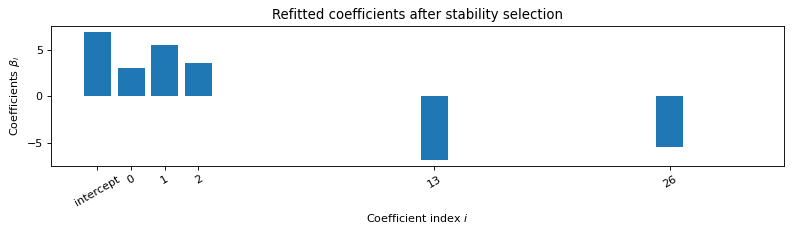


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.067s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.1   5.51  3.6   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.77  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.44  0.    0.    0.  ]
Error: 3632.06

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


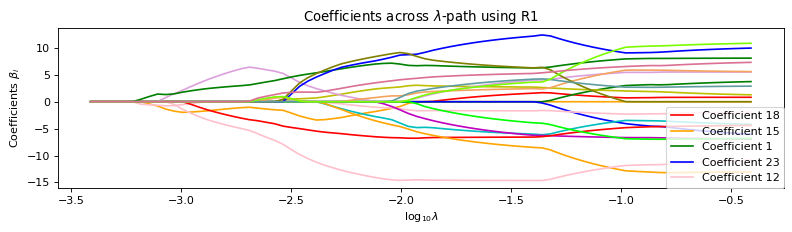

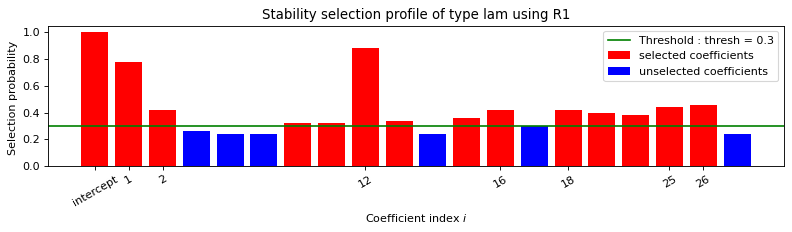

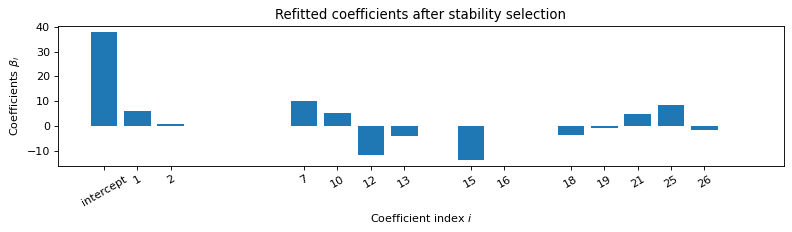


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    10    12    13    15    16    18    19    21    25    26    
   Running time :  0.139s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     6.06   0.64   0.     0.     0.     0.    10.29   0.     0.
   5.2    0.   -11.56  -4.15   0.   -13.59   0.1    0.    -3.45  -0.96
   0.     4.72   0.     0.     0.     8.49  -1.77   0.     0.     0.  ]
Error: 2157.38

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


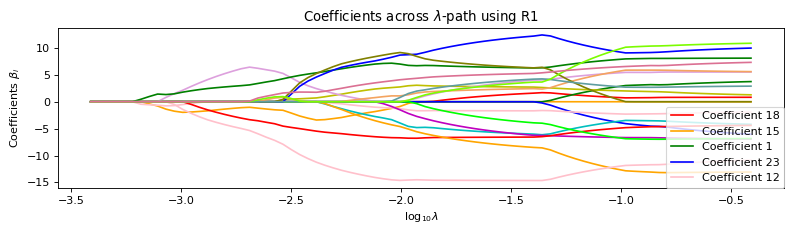

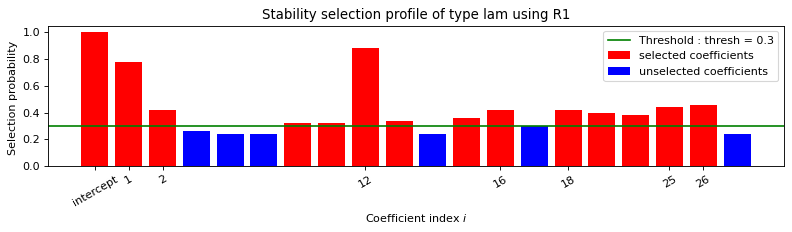

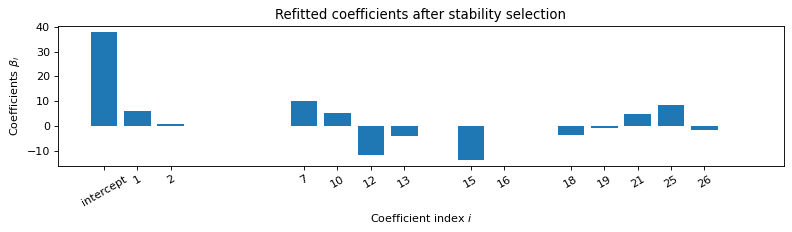

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    10    12    13    15    16    18    19    21    25    26    
   Running time :  0.141s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-4.29  1.95  1.93  1.5   1.22  1.03 -8.73  2.    1.79 -3.34  1.93 12.89
  4.79  0.45 13.58 -0.53 -0.4   2.98  0.4  -0.56 -5.15 -0.3  -0.29 -0.27
 -8.59  1.81  0.    0.    0.  ]
Error: 2157.52

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.23200577]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573227]...
INFO:absl:Predict treatment effect...


Error: 633.68

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3689.43

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2739.46

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -31.672
Model:                         IV2SLS   Adj. R-squared:                -33.688
Method:                     Two Stage   F-statistic:                 -0.008744
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:15:32                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -129.7266   6.53e+08  -1.99e-07      1.0

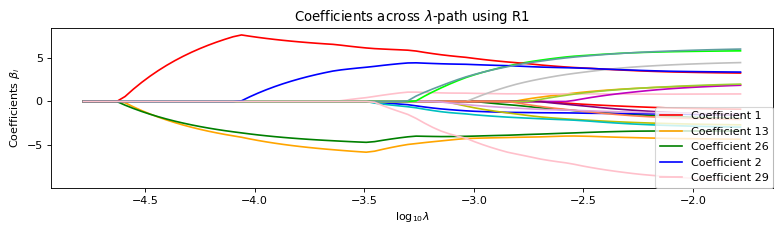

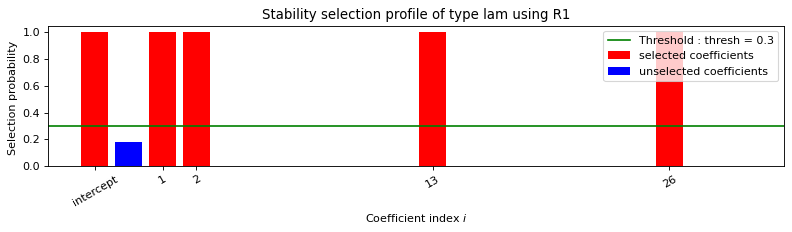

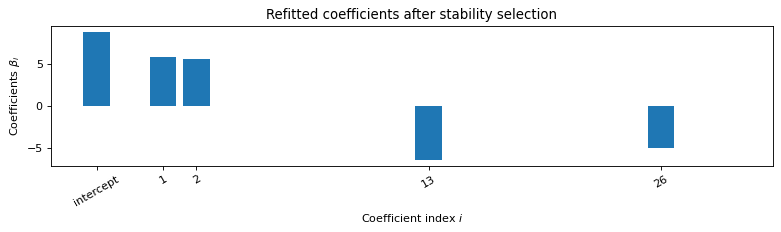


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.107s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.88  5.6   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.41  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.06  0.    0.    0.  ]
Error: 3280.1

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


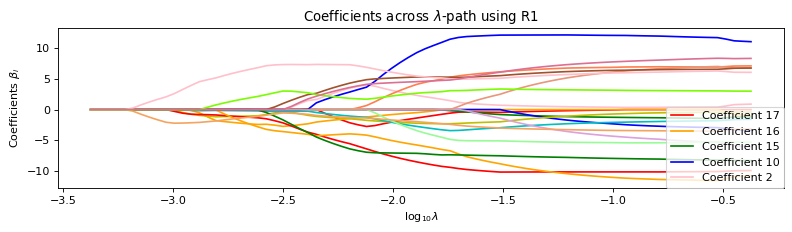

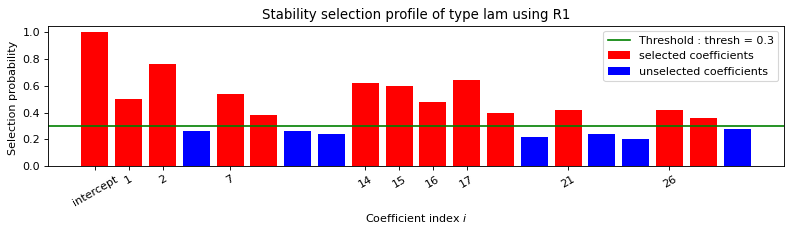

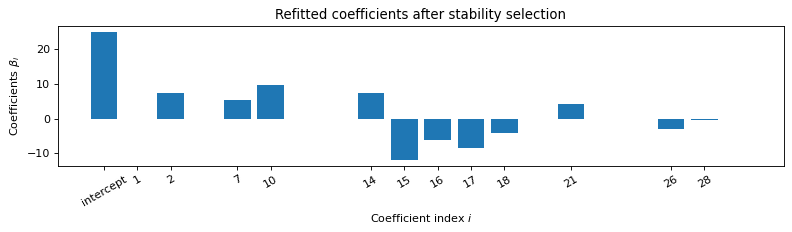


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    10    14    15    16    17    18    21    26    28    
   Running time :  0.159s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -0.16   7.4    0.     0.     0.     0.     5.47   0.     0.
   9.67   0.     0.     0.     7.52 -11.81  -6.23  -8.51  -4.1    0.
   0.     4.18   0.     0.     0.     0.    -3.06   0.    -0.38   0.  ]
Error: 2954.18

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


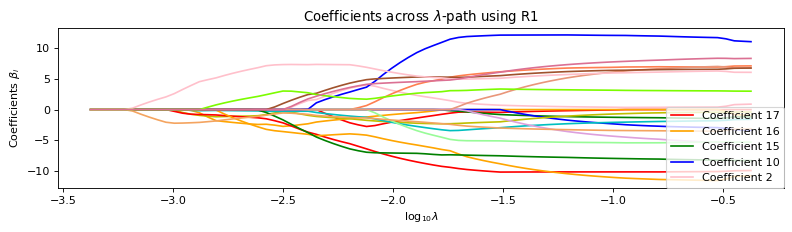

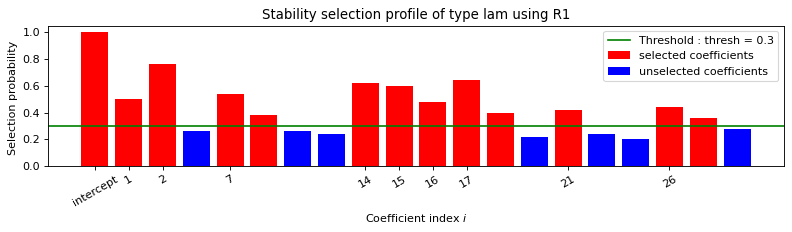

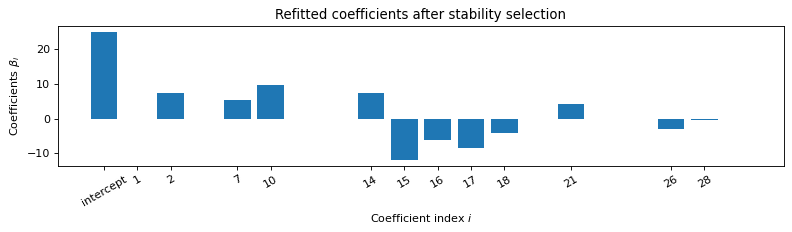

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    10    14    15    16    17    18    21    26    28    
   Running time :  0.55s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 1.100e-01 -6.110e+00  2.090e+00  1.620e+00  1.320e+00  1.120e+00
 -4.150e+00  1.500e+00  1.340e+00 -8.010e+00  1.950e+00  1.790e+00
  1.660e+00 -5.720e+00  1.337e+01  7.140e+00  8.950e+00  4.170e+00
 -4.000e-02 -4.000e-02 -4.120e+00  1.500e-01  1.500e-01  1.400e-01
  1.300e-01  3.130e+00  1.000e-02  3.800e-01  0.000e+00]
Error: 2954.18

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.34484281]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573227]...
INFO:absl:Predict treatment effect...


Error: 719.56

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3309.83

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2841.22

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -3.845
Model:                         IV2SLS   Adj. R-squared:                 -4.144
Method:                     Two Stage   F-statistic:                   0.02533
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:17:45                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1092   3.91e+08   6.42e-08      1.0

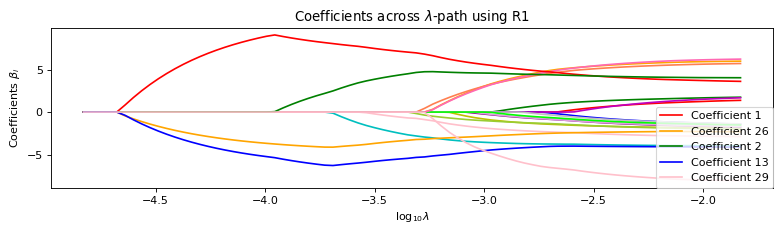

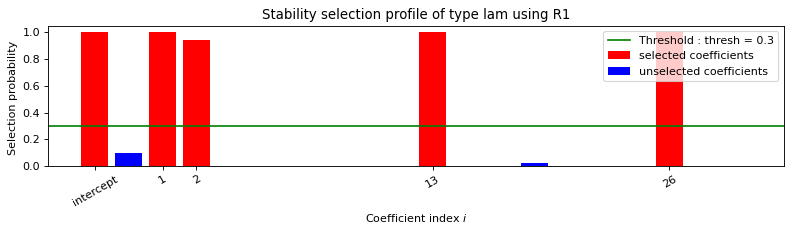

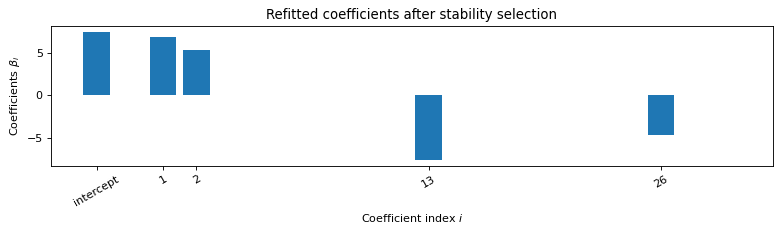


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.073s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    6.86  5.32  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.53  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.65  0.    0.    0.  ]
Error: 3401.22

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


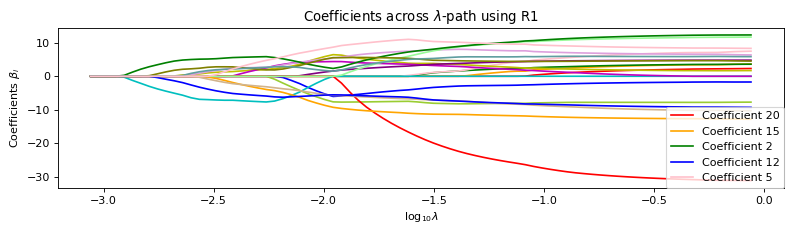

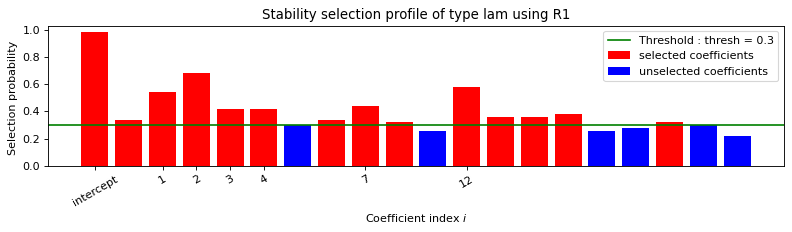

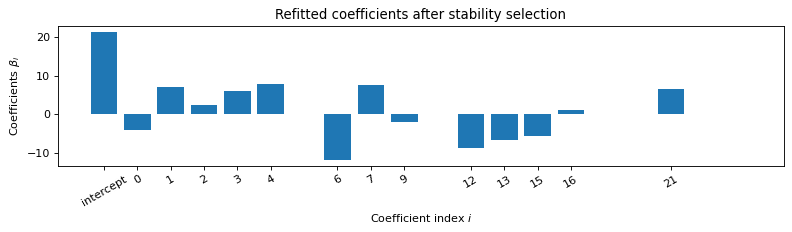


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    3    4    6    7    9    12    13    15    16    21    
   Running time :  0.202s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -4.14   6.98   2.53   6.06   7.94   0.   -11.76   7.5    0.    -1.89
   0.     0.    -8.64  -6.8    0.    -5.52   1.09   0.     0.     0.
   0.     6.65   0.     0.     0.     0.     0.     0.     0.     0.  ]
Error: 3241.39

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


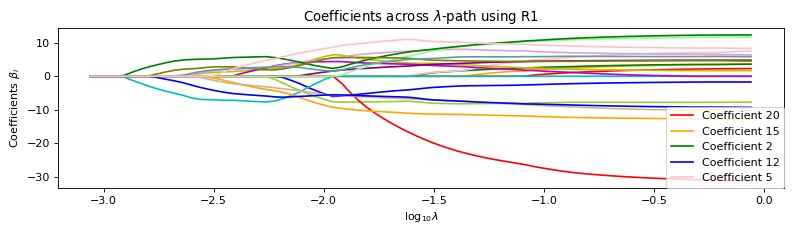

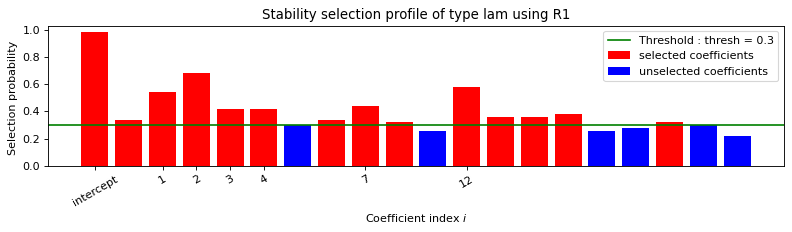

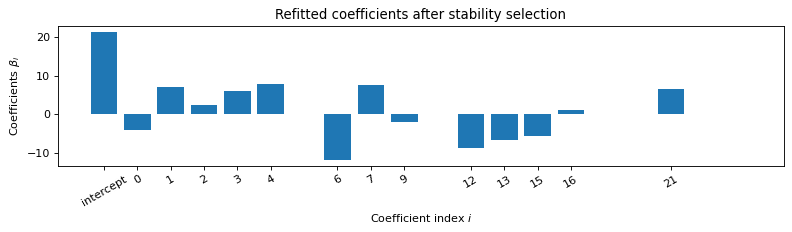

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.014s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    3    4    6    7    9    12    13    15    16    21    
   Running time :  0.18s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-7.87 -0.9  -3.7  -4.55  3.54 13.88 -6.    1.78  3.38  1.26  1.15  9.36
  6.9  -0.15  5.2  -1.53 -0.38 -0.36 -0.34 -0.32 -6.81  0.    0.    0.
  0.    0.    0.    0.    0.  ]
Error: 3241.41

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.19542728]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 845.04

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3310.61

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4480.31

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -6.661
Model:                         IV2SLS   Adj. R-squared:                 -7.134
Method:                     Two Stage   F-statistic:                  0.009733
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:20:58                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.1520        nan        nan        n

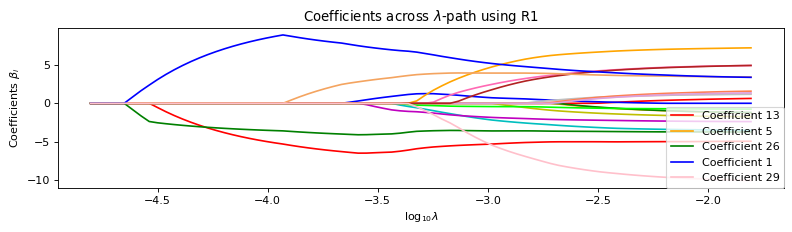

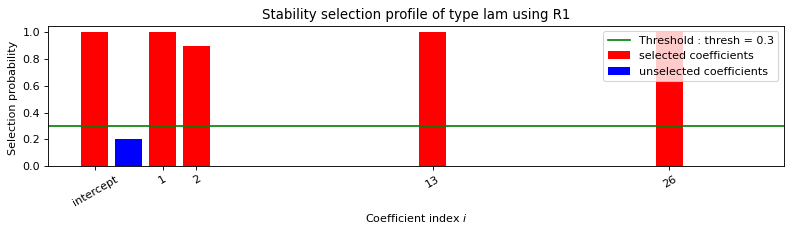

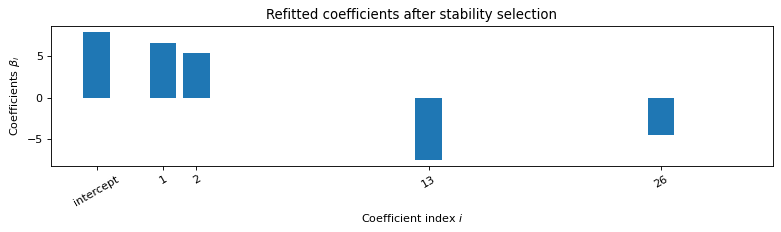


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.077s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    6.54  5.37  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.43  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.48  0.    0.    0.  ]
Error: 3523.77

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


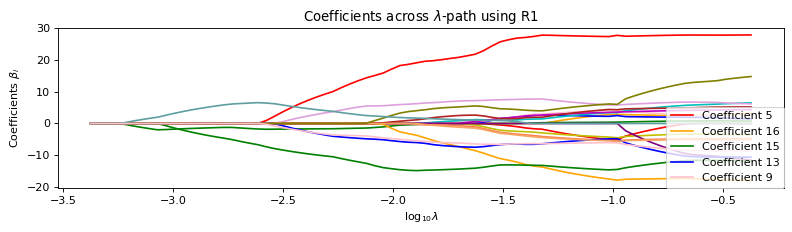

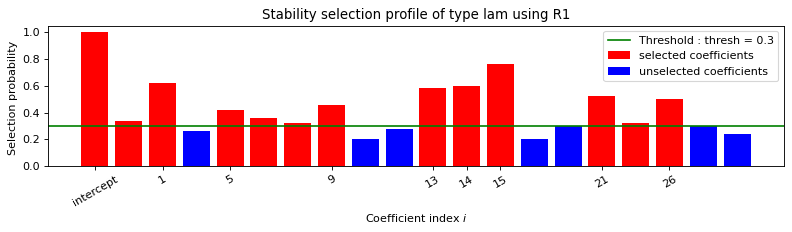

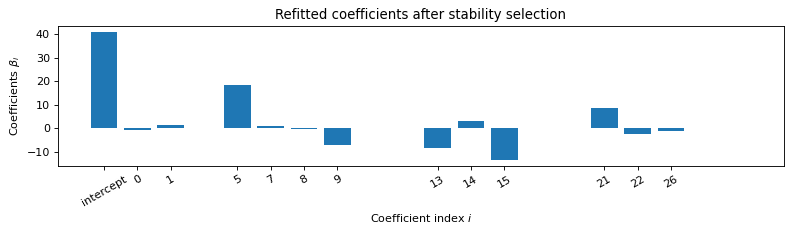


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    5    7    8    9    13    14    15    21    22    26    
   Running time :  0.134s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -0.74   1.46   0.     0.     0.    18.45   0.     1.06  -0.16  -6.84
   0.     0.     0.    -8.33   3.15 -13.24   0.     0.     0.     0.
   0.     8.72  -2.36   0.     0.     0.    -1.16   0.     0.     0.  ]
Error: 2154.19

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


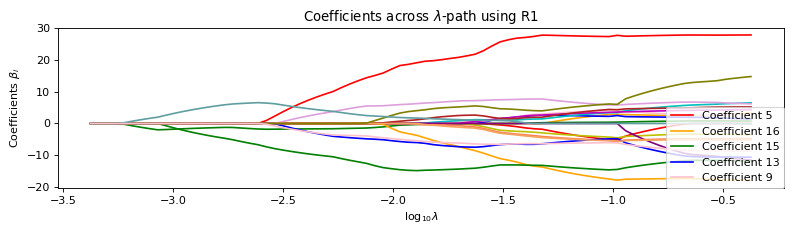

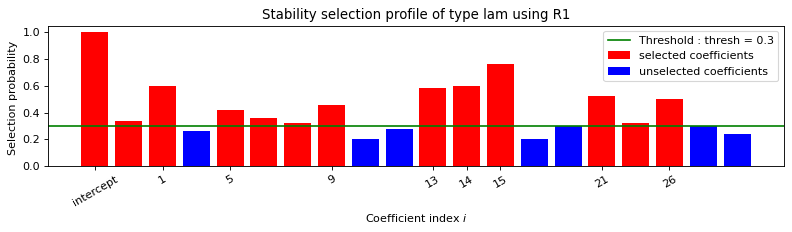

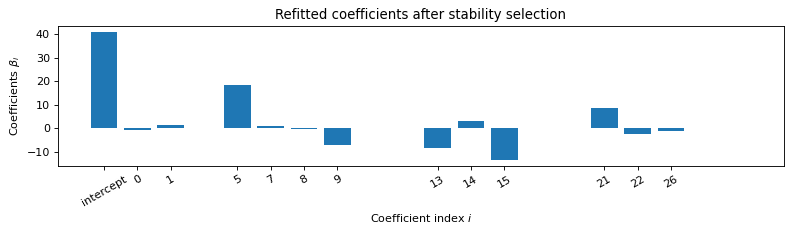

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    5    7    8    9    13    14    15    21    22    26    
   Running time :  0.131s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -1.56   0.29   0.21   0.16 -16.71   2.96   1.57   2.54   8.6    1.26
   1.15   1.06   9.    -2.71  13.34  -0.32  -0.3   -0.28  -0.27  -0.25
  -8.76   2.46   0.05   0.05   0.05   1.18   0.     0.     0.  ]
Error: 2154.2

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.5231825]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 865.75

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3585.1

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4091.91

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                 -726295.122
Model:                         IV2SLS   Adj. R-squared:            -771109.138
Method:                     Two Stage   F-statistic:                 2.349e-05
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:23:48                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.686e+04        nan        nan        n

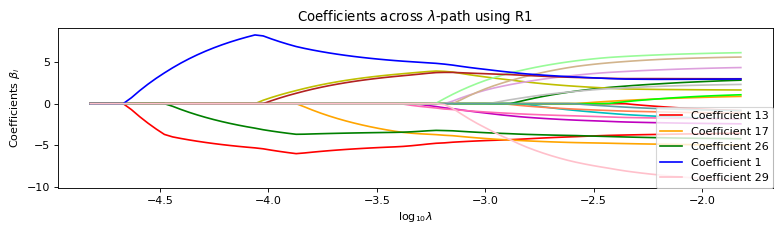

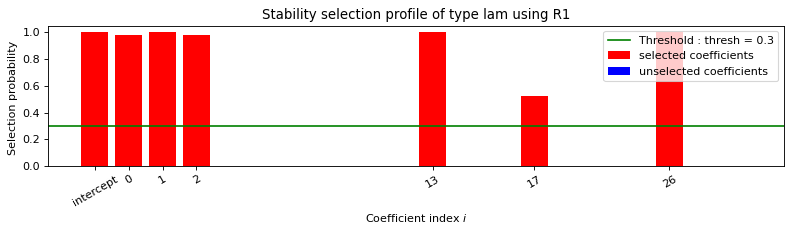

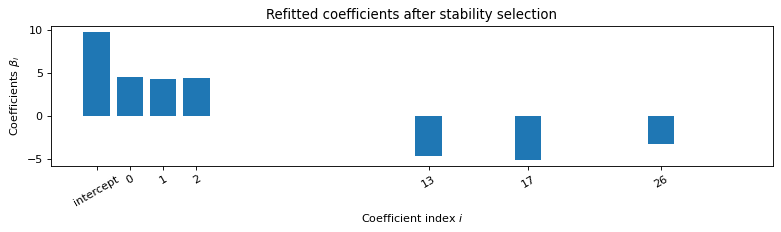


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.078s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 4.55  4.26  4.35  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -4.72  0.    0.    0.   -5.12  0.    0.    0.    0.    0.    0.
  0.    0.   -3.31  0.    0.    0.  ]
Error: 2918.89

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


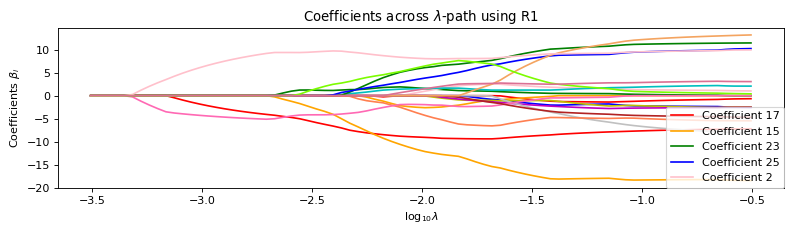

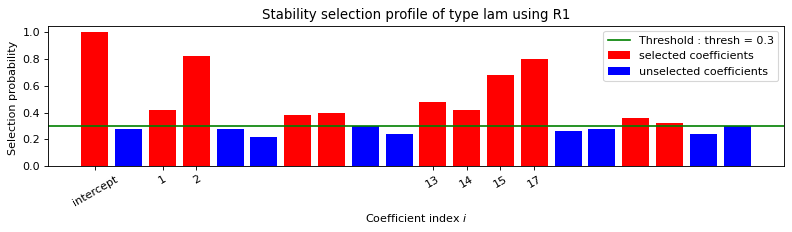

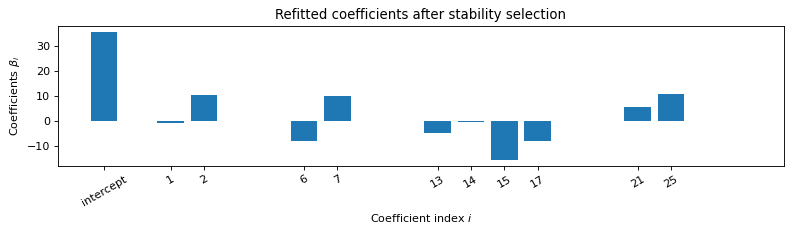


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    6    7    13    14    15    17    21    25    
   Running time :  0.142s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -0.71  10.61   0.     0.     0.    -8.    10.06   0.     0.
   0.     0.     0.    -4.84  -0.39 -15.46   0.    -7.92   0.     0.
   0.     5.68   0.     0.     0.    10.96   0.     0.     0.     0.  ]
Error: 2880.73

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


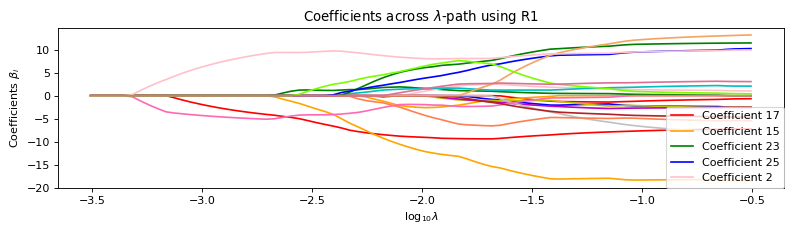

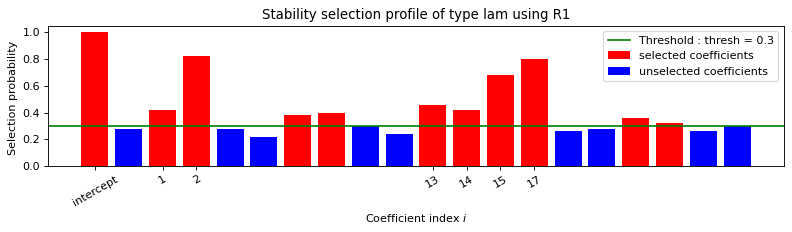

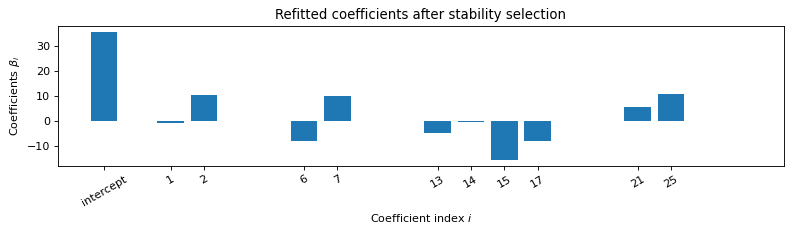

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    6    7    13    14    15    17    21    25    
   Running time :  0.165s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.5   -8.96   2.86   2.21   1.81   8.94  -9.16   1.41   1.26   1.14
   1.04   0.96   5.55   0.87  15.4   -0.53   7.2   -0.9   -0.85  -0.81
  -6.33  -0.49  -0.47  -0.45 -11.17   0.     0.     0.     0.  ]
Error: 2880.73

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.59288436]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573227]...
INFO:absl:Predict treatment effect...


Error: 614.64

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2939.96

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2818.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -1.784
Model:                         IV2SLS   Adj. R-squared:                 -1.956
Method:                     Two Stage   F-statistic:                 -0.003637
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:26:25                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -23.5408   1.19e+08  -1.98e-07      1.0

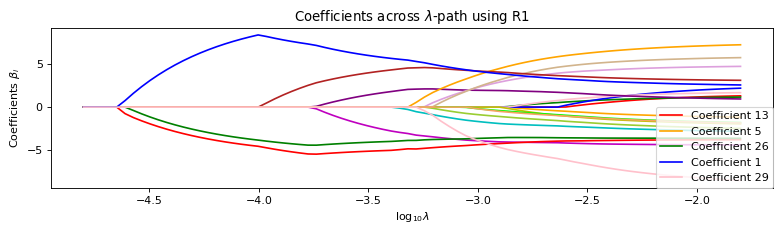

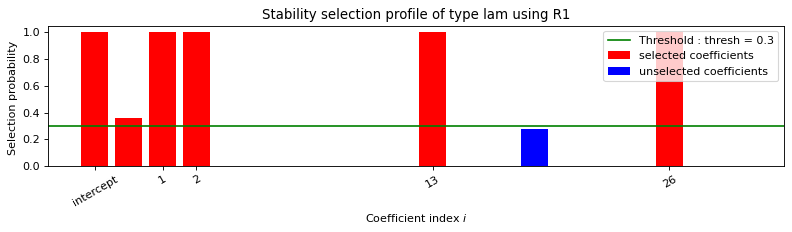

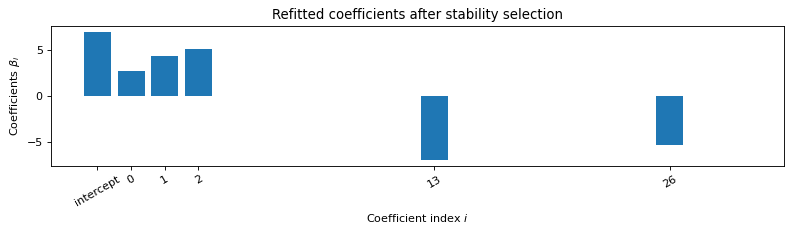


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.093s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.71  4.35  5.17  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.93  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.3   0.    0.    0.  ]
Error: 3340.48

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


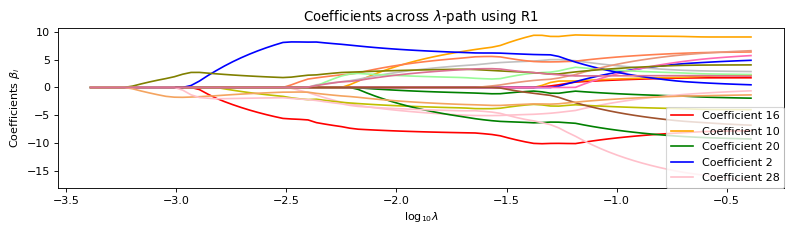

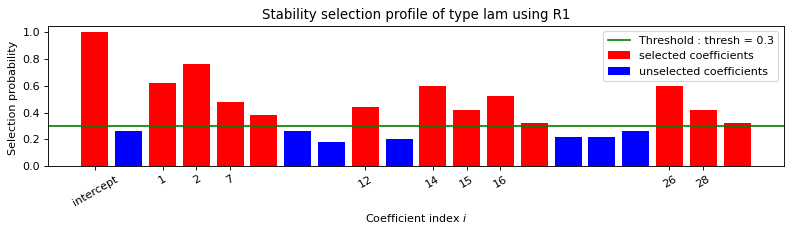

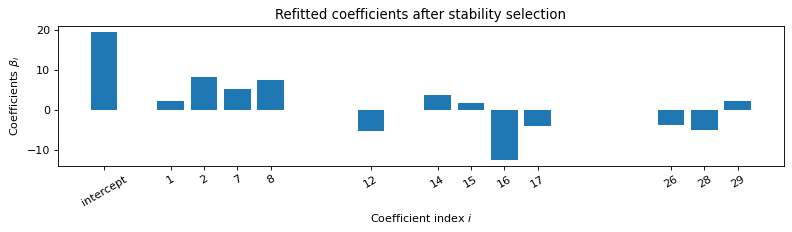


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    12    14    15    16    17    26    28    29    
   Running time :  0.171s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     2.11   8.25   0.     0.     0.     0.     5.29   7.52   0.
   0.     0.    -5.35   0.     3.71   1.64 -12.45  -3.97   0.     0.
   0.     0.     0.     0.     0.     0.    -3.7    0.    -5.16   2.09]
Error: 3207.3

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


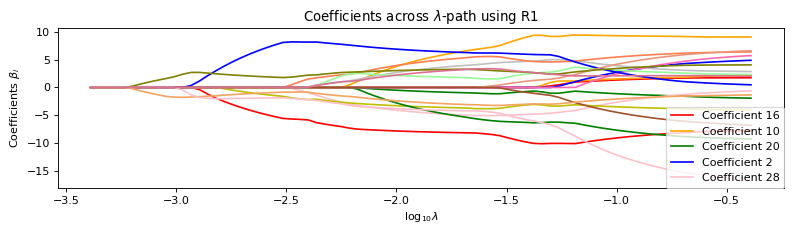

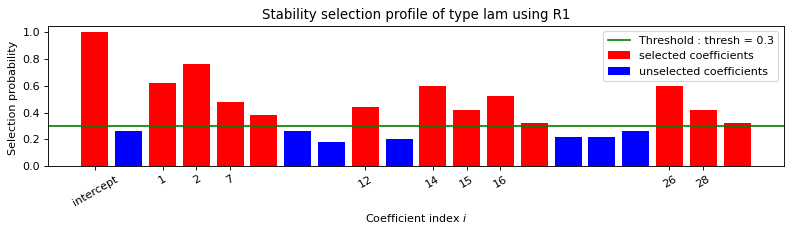

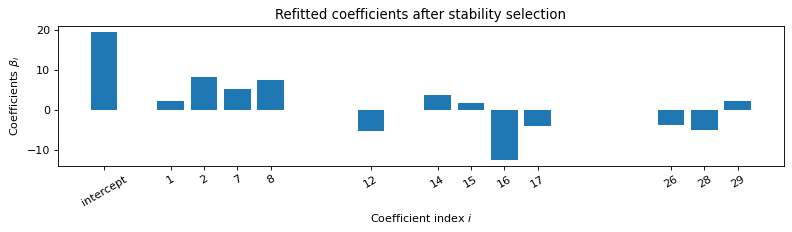

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    12    14    15    16    17    26    28    29    
   Running time :  0.152s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-1.49 -5.88  2.99  2.32  1.89  1.6  -3.56 -5.25  2.44  2.21  2.02  7.
  1.32 -2.36 -0.2  13.49  4.47  0.37  0.35  0.33  0.31  0.3   0.29  0.28
  0.27  3.88  0.11  5.18 -2.13]
Error: 3207.3

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.53626812]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 765.25

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3385.13

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2294.71

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -0.454
Model:                         IV2SLS   Adj. R-squared:                 -0.544
Method:                     Two Stage   F-statistic:                   0.03020
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:29:37                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6350   8.42e+07  -3.13e-08      1.0

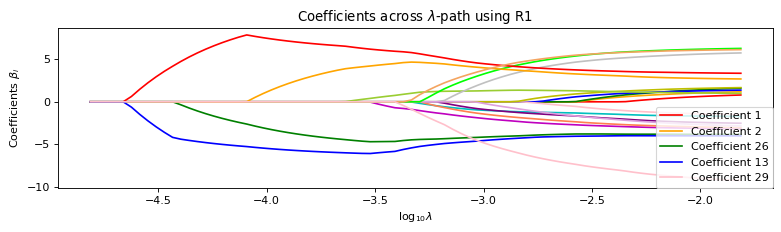

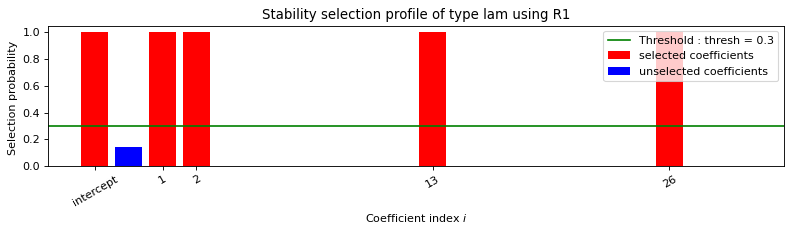

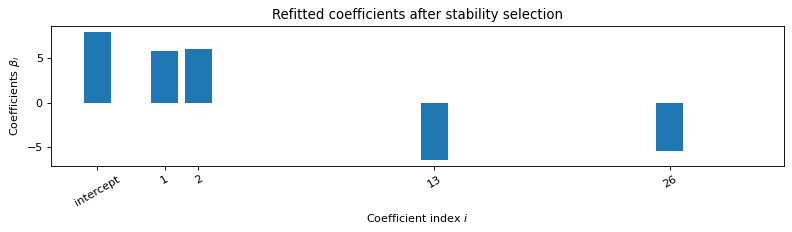


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.095s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.83  5.99  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.39  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.43  0.    0.    0.  ]
Error: 3443.53

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


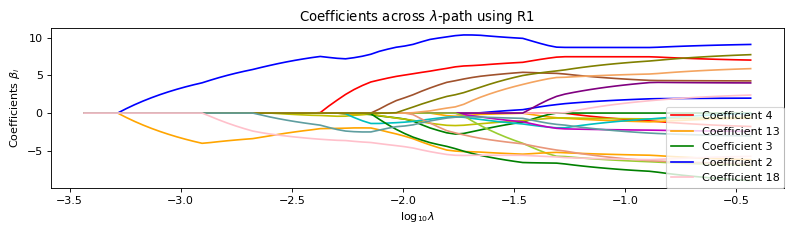

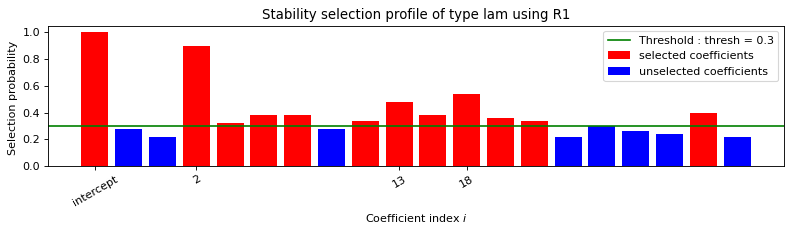

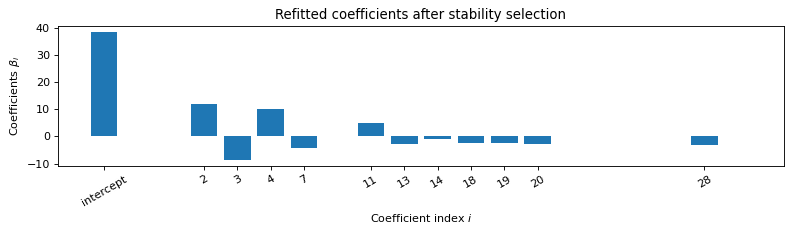


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.012s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    3    4    7    11    13    14    18    19    20    28    
   Running time :  0.271s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    0.   12.01 -8.54 10.15  0.    0.   -4.2   0.    0.    0.    4.99
  0.   -2.85 -0.81  0.    0.    0.   -2.54 -2.31 -2.7   0.    0.    0.
  0.    0.    0.    0.   -3.19  0.  ]
Error: 2026.96

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


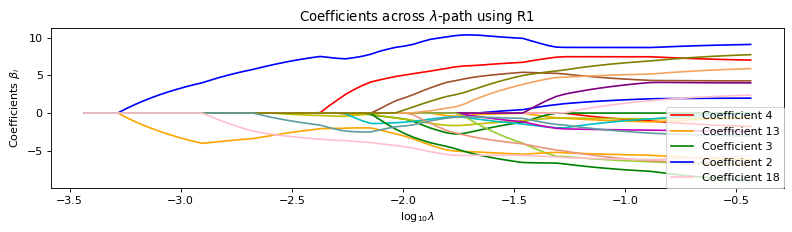

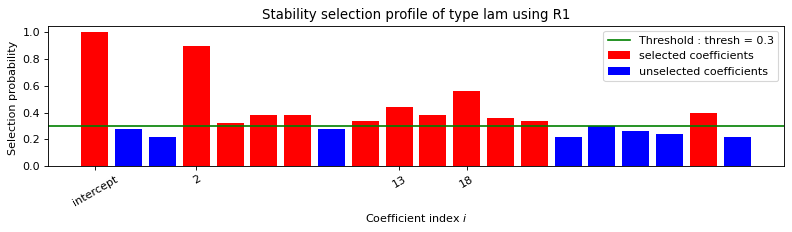

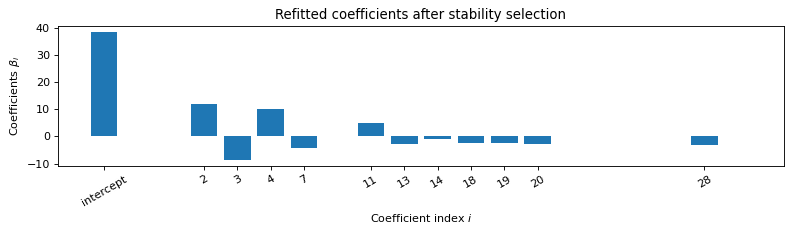

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    3    4    7    11    13    14    18    19    20    28    
   Running time :  0.202s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.   -9.81 10.86 -8.3   2.49  2.1   5.75  1.11  0.99  0.9  -3.96  1.15
  3.81  1.58  0.69  0.65  0.61  3.06  2.67  2.92  0.15  0.14  0.14  0.13
  0.13  0.12  0.12  3.25  0.  ]
Error: 2026.96

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.41261642]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573487]...
INFO:absl:Predict treatment effect...


Error: 762.37

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3450.76

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2109.68

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -34.415
Model:                         IV2SLS   Adj. R-squared:                -36.600
Method:                     Two Stage   F-statistic:                 0.0005431
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:32:37                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3971        nan        nan        n

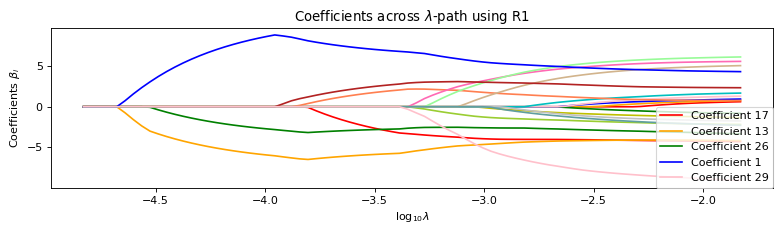

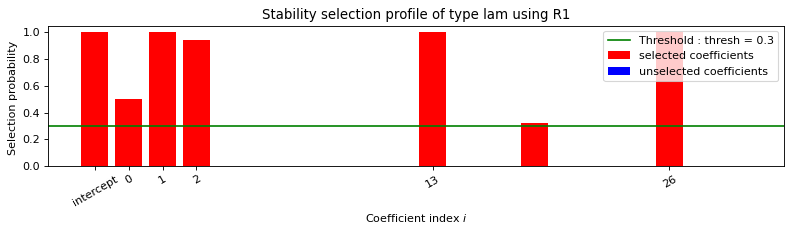

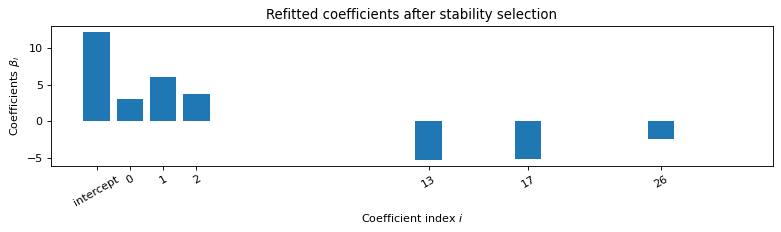


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    17    26    
   Running time :  0.055s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.11  6.02  3.79  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -5.27  0.    0.    0.   -5.19  0.    0.    0.    0.    0.    0.
  0.    0.   -2.46  0.    0.    0.  ]
Error: 3751.53

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


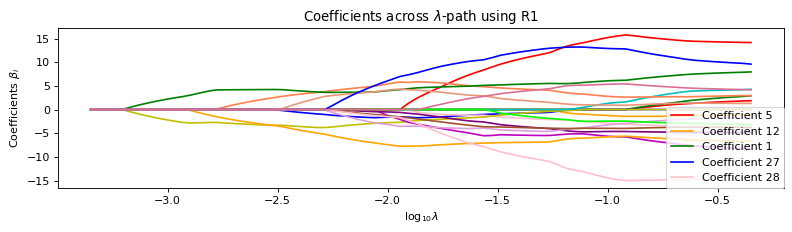

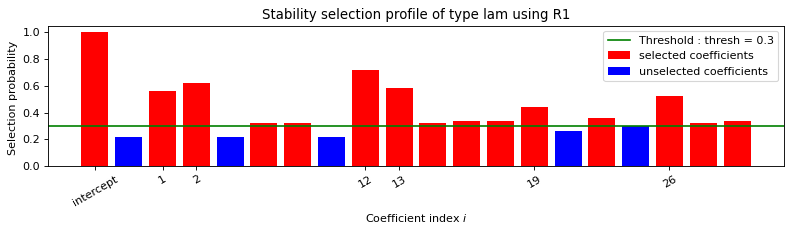

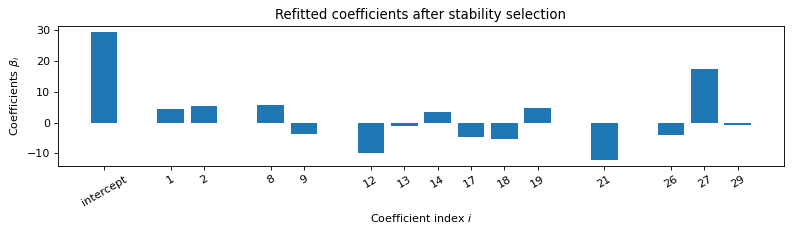


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    8    9    12    13    14    17    18    19    21    26    27    29    
   Running time :  0.129s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     4.26   5.47   0.     0.     0.     0.     0.     5.86  -3.58
   0.     0.    -9.97  -1.07   3.5    0.     0.    -4.67  -5.26   4.59
   0.   -11.98   0.     0.     0.     0.    -3.91  17.51   0.    -0.76]
Error: 2483.7

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


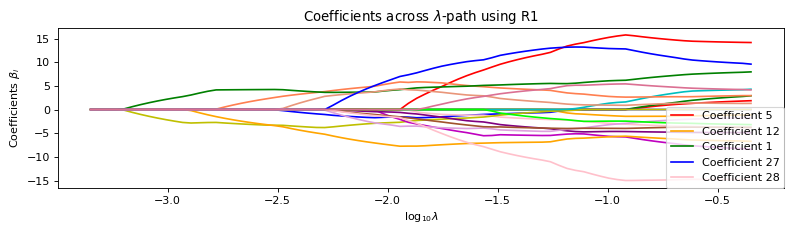

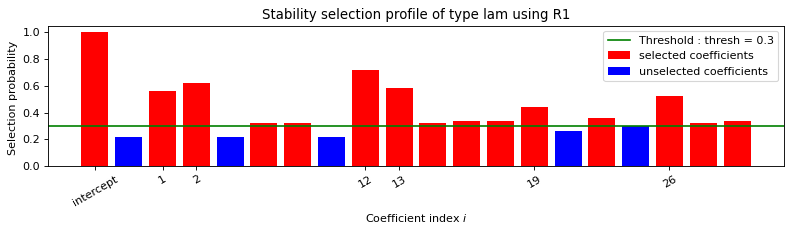

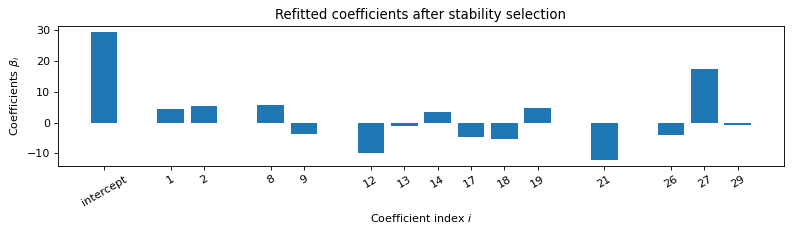

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    8    9    12    13    14    17    18    19    21    26    27    29    
   Running time :  0.12s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -3.01  -2.73   2.81   2.17   1.78   1.5    1.3   -4.38   5.04   1.14
   1.05  10.54   1.18  -3.32   0.29   0.27   4.79   5.11  -4.76  -0.04
  11.67  -0.57  -0.55  -0.52  -0.5    3.35 -17.8    0.03   0.78]
Error: 2483.7

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [1.63307937]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-2.99570901]...
INFO:absl:Predict treatment effect...


Error: 1010.5

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3713.42

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2547.88

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -471.678
Model:                         IV2SLS   Adj. R-squared:               -500.843
Method:                     Two Stage   F-statistic:                -3.839e-05
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:34:48                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        629.9040        nan        nan        n

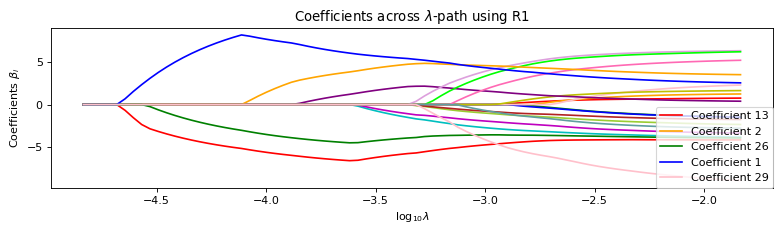

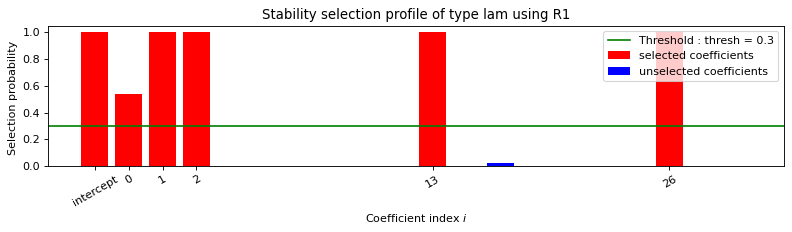

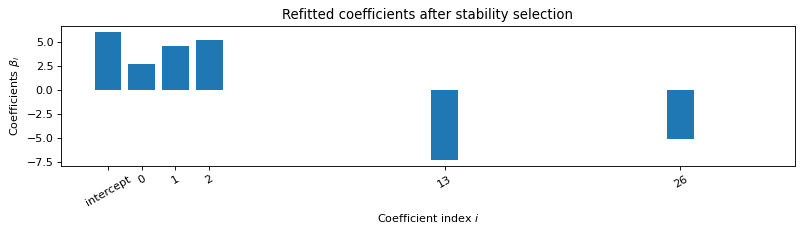


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.005s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.057s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.72  4.56  5.18  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.29  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.17  0.    0.    0.  ]
Error: 3529.66

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


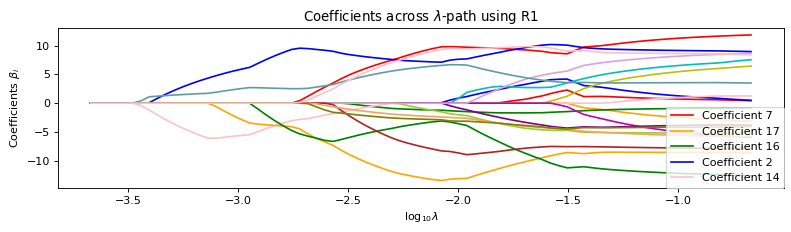

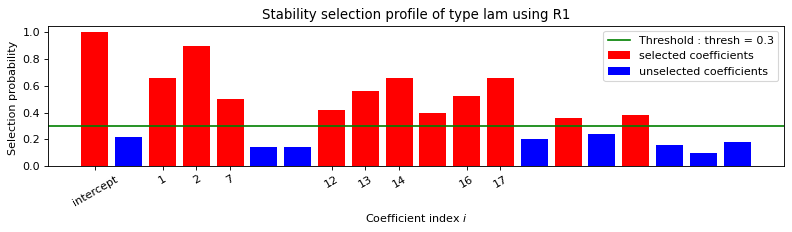

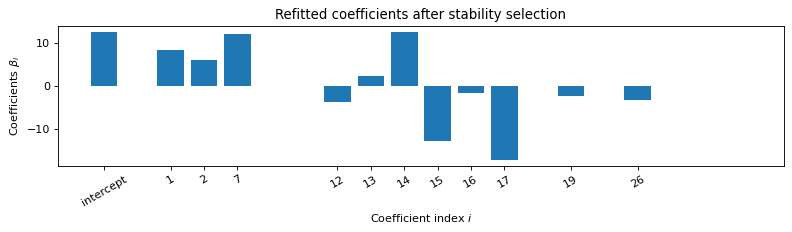


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.005s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    17    19    26    
   Running time :  0.098s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     8.35   6.11   0.     0.     0.     0.    12.07   0.     0.
   0.     0.    -3.82   2.18  12.53 -12.91  -1.59 -17.19   0.    -2.35
   0.     0.     0.     0.     0.     0.    -3.4    0.     0.     0.  ]
Error: 4980.45

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


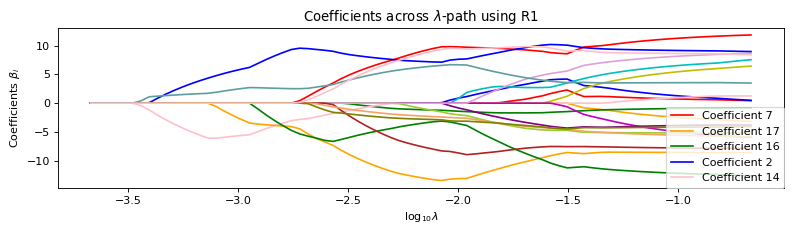

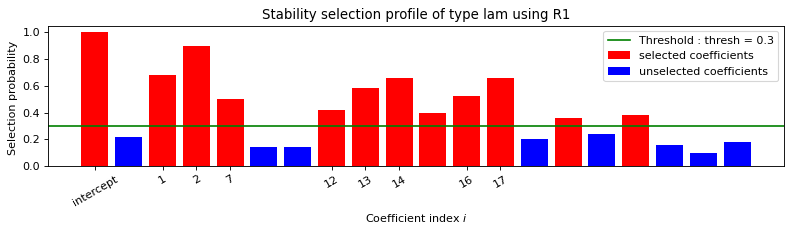

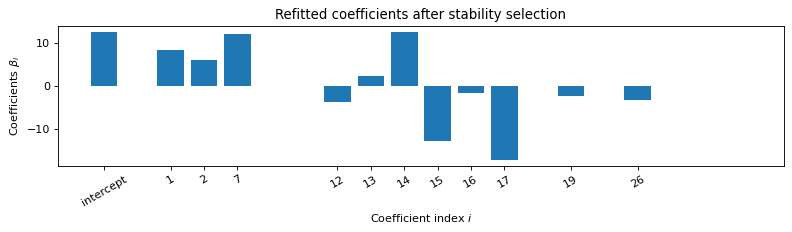

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    17    19    26    
   Running time :  0.107s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -5.91  -1.57   4.17   3.23   2.64   2.23  -9.36   3.13   2.8    2.53
   2.31   5.79  -0.42 -10.39  14.92   3.03  18.01   0.31   2.58   0.17
   0.16   0.15   0.14   0.14   0.13   3.46   0.     0.     0.  ]
Error: 4980.54

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.20565823]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99582757]...
INFO:absl:Predict treatment effect...


Error: 910.88

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3520.01

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3786.17

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -1.971
Model:                         IV2SLS   Adj. R-squared:                 -2.154
Method:                     Two Stage   F-statistic:                  0.007300
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:36:33                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.1869        nan        nan        n

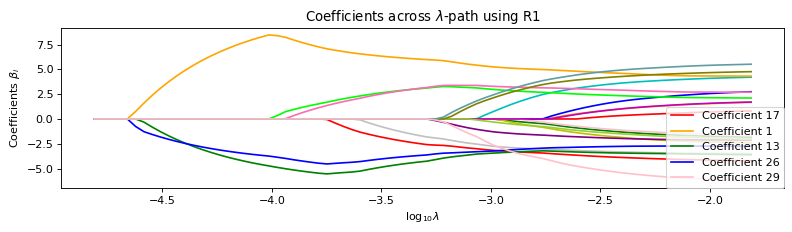

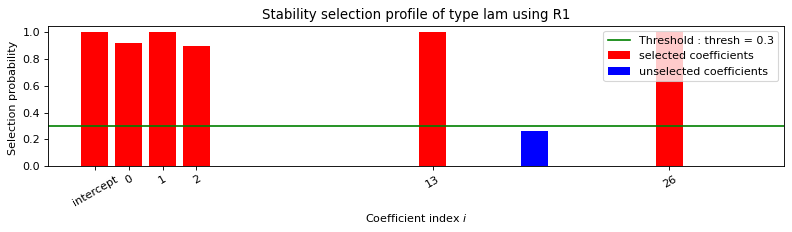

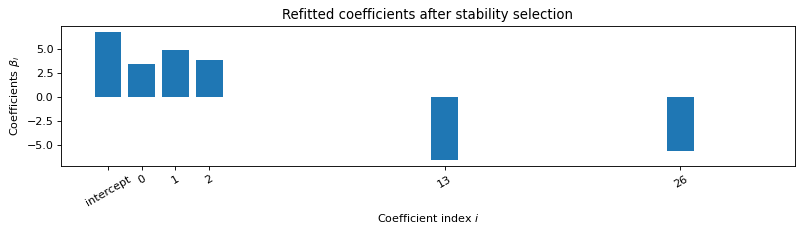


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.061s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.43  4.94  3.8   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.55  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.62  0.    0.    0.  ]
Error: 3816.25

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


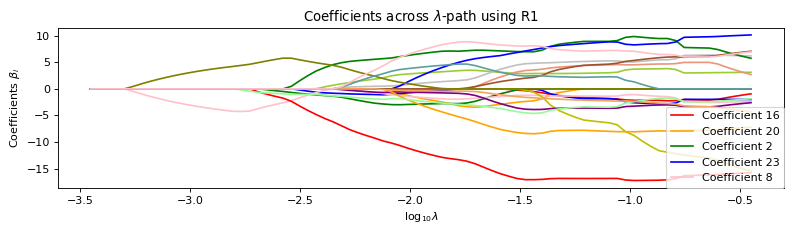

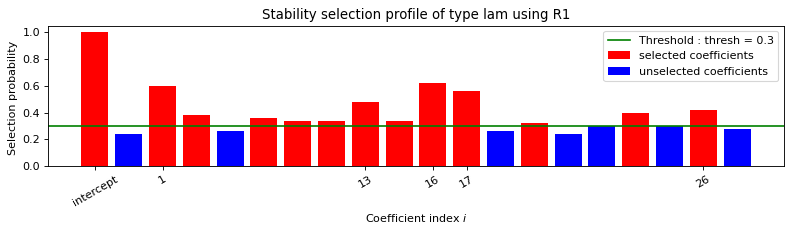

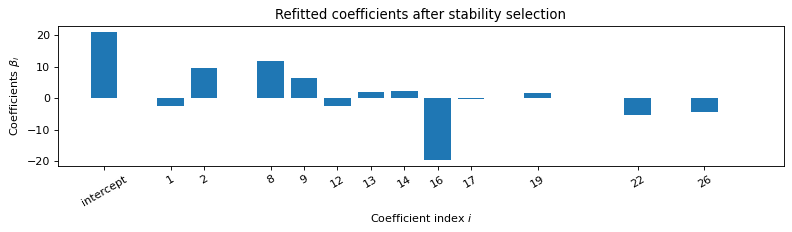


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    8    9    12    13    14    16    17    19    22    26    
   Running time :  0.112s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -2.49   9.48   0.     0.     0.     0.     0.    11.85   6.59
   0.     0.    -2.54   2.15   2.25   0.   -19.42  -0.1    0.     1.76
   0.     0.    -5.15   0.     0.     0.    -4.38   0.     0.     0.  ]
Error: 3356.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


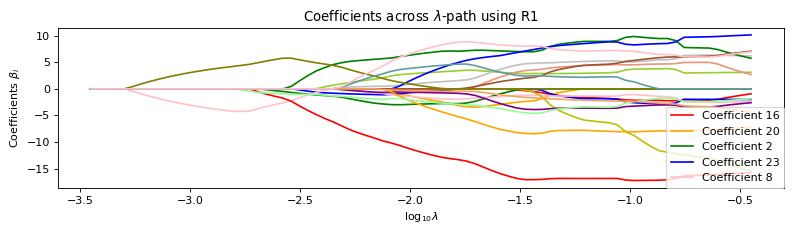

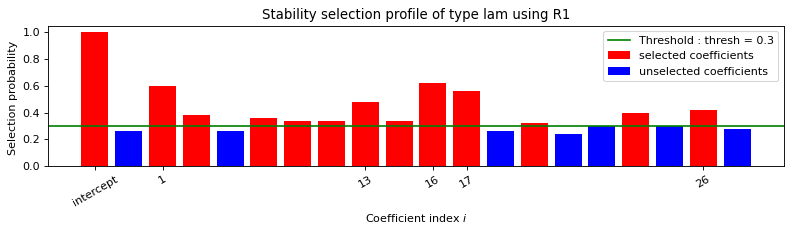

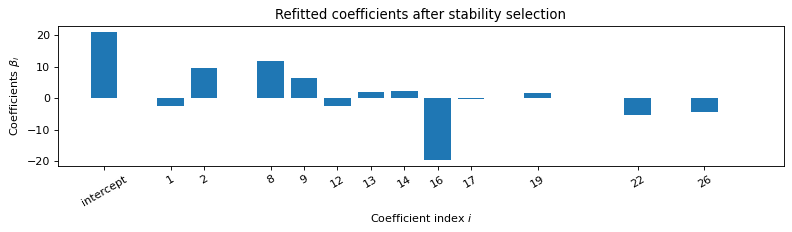

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    8    9    12    13    14    16    17    19    22    26    
   Running time :  0.118s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  1.76  -8.76   2.02   1.56   1.28   1.08   0.93 -10.35  -4.26   2.42
   2.21   4.47  -0.37  -0.45   1.76  20.5    0.54   0.42  -1.32   0.47
   0.44   5.46   0.19   0.18   0.17   4.47   0.     0.     0.  ]
Error: 3356.58

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.04913759]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99571734]...
INFO:absl:Predict treatment effect...


Error: 933.64

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3805.01

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2977.03

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -117.826
Model:                         IV2SLS   Adj. R-squared:               -125.158
Method:                     Two Stage   F-statistic:                 -0.003803
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:38:19                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -202.8528        nan        nan        n

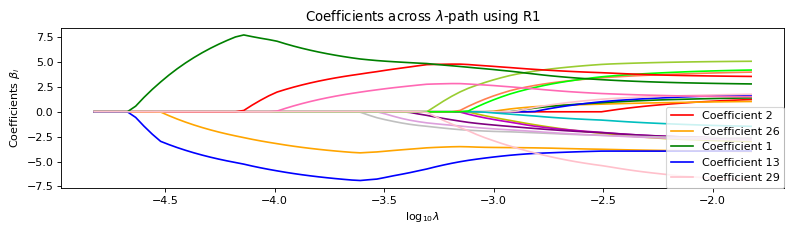

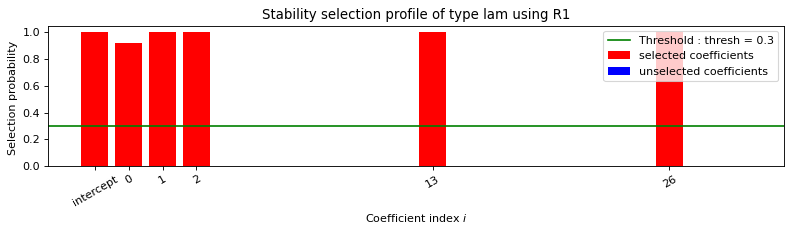

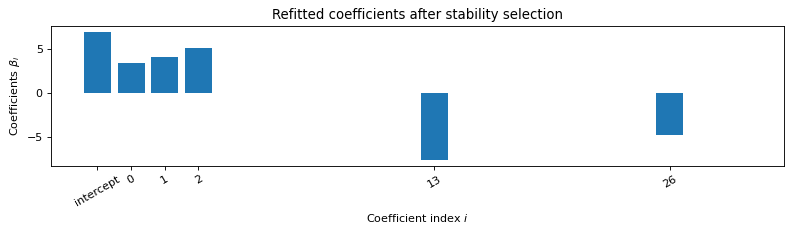


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.061s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.33  4.02  5.08  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.62  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.81  0.    0.    0.  ]
Error: 3903.19

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


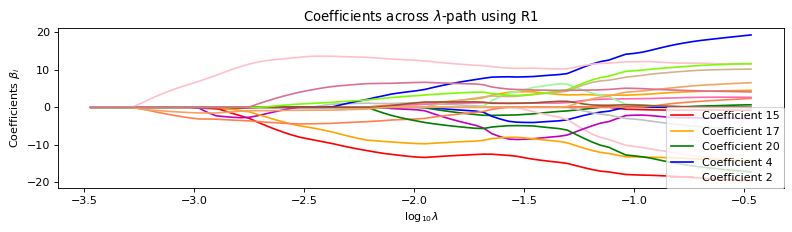

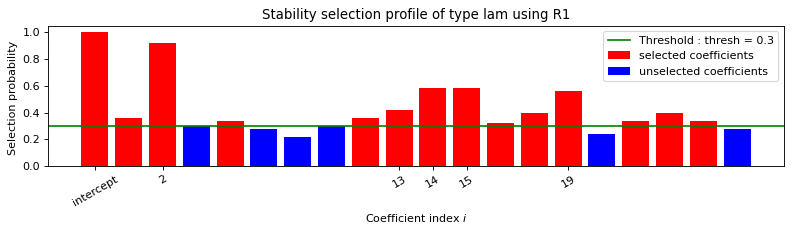

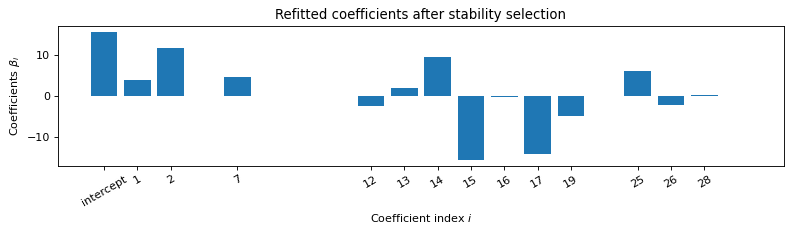


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    17    19    25    26    28    
   Running time :  0.115s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     3.95  11.94   0.     0.     0.     0.     4.84   0.     0.
   0.     0.    -2.28   2.01   9.58 -15.42  -0.21 -13.93   0.    -4.68
   0.     0.     0.     0.     0.     6.14  -2.17   0.     0.24   0.  ]
Error: 4447.45

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


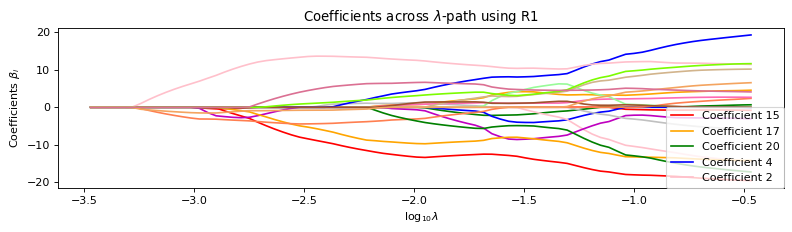

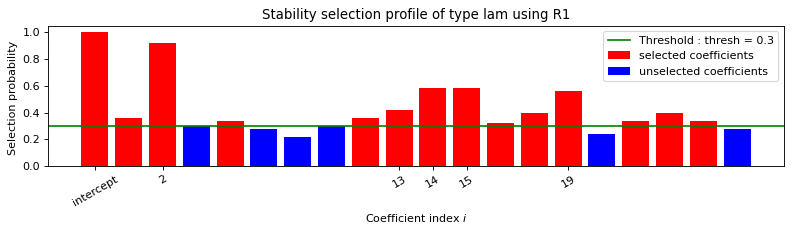

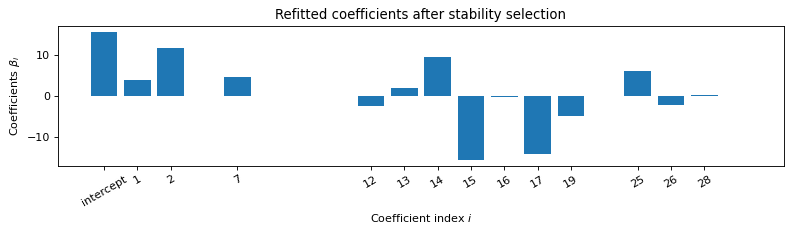

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    12    13    14    15    16    17    19    25    26    28    
   Running time :  0.112s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-2.790e+00 -8.130e+00  4.590e+00  3.550e+00  2.900e+00  2.450e+00
 -2.410e+00  2.440e+00  2.180e+00  1.980e+00  1.800e+00  3.850e+00
 -5.700e-01 -7.850e+00  1.687e+01  1.090e+00  1.436e+01  3.000e-02
  4.580e+00 -2.100e-01 -2.000e-01 -1.900e-01 -1.800e-01 -1.700e-01
 -6.190e+00  2.200e+00 -1.000e-02 -2.400e-01  0.000e+00]
Error: 4447.45

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.43250383]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99587621]...
INFO:absl:Predict treatment effect...


Error: 869.97

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3859.24

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4647.62

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 12

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -204.617
Model:                         IV2SLS   Adj. R-squared:               -217.304
Method:                     Two Stage   F-statistic:                 -0.003727
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:40:05                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.4052        nan        nan        n

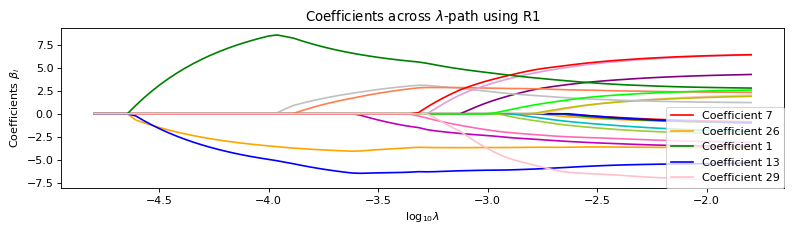

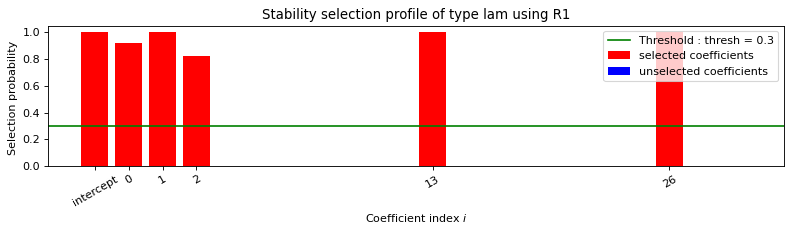

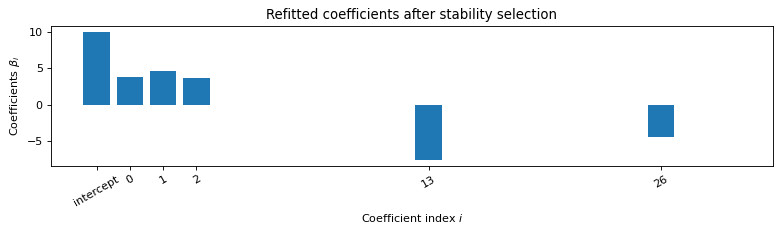


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.057s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.77  4.66  3.63  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.61  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.45  0.    0.    0.  ]
Error: 3398.9

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


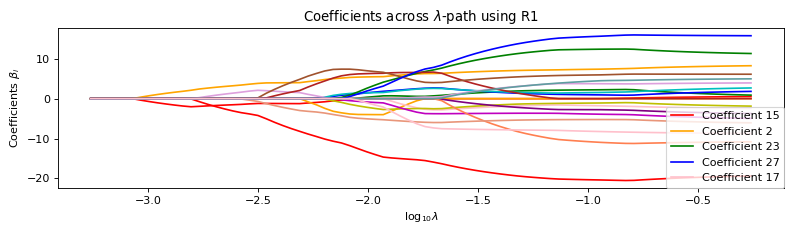

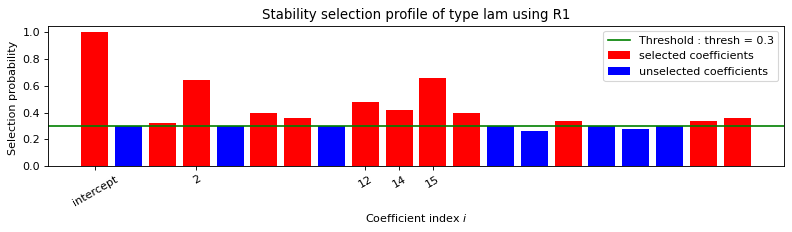

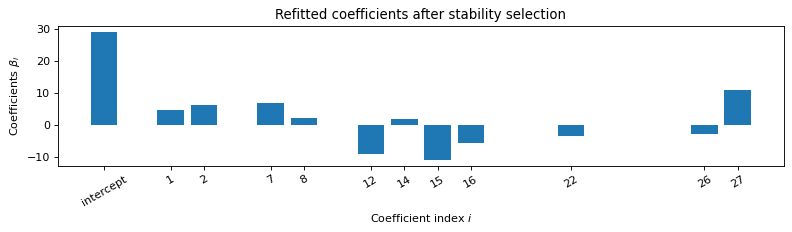


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    12    14    15    16    22    26    27    
   Running time :  0.127s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     4.5    6.17   0.     0.     0.     0.     6.83   2.     0.
   0.     0.    -9.21   0.     1.79 -10.82  -5.69   0.     0.     0.
   0.     0.    -3.46   0.     0.     0.    -2.98  10.87   0.     0.  ]
Error: 2587.13

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


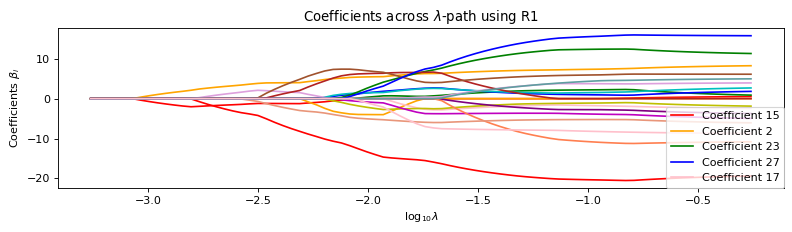

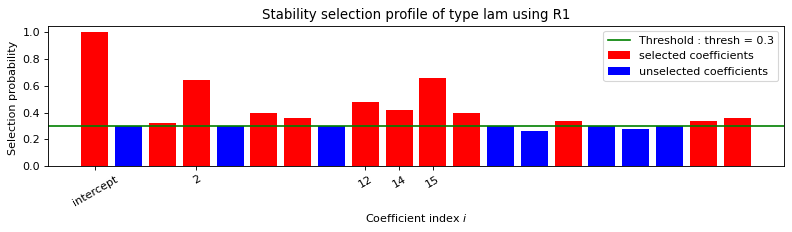

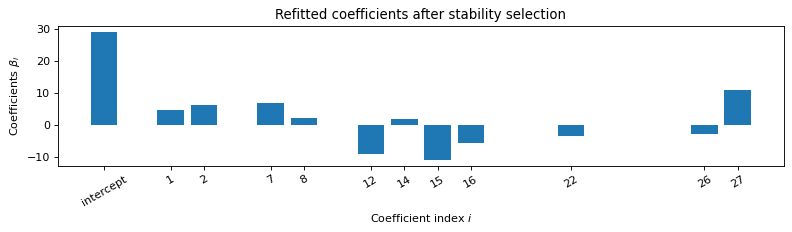

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    8    12    14    15    16    22    26    27    
   Running time :  0.163s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -3.18  -3.2    3.08   2.38   1.95   1.65  -4.97   0.17   2.06   1.86
   1.7   10.41   0.76  -1.02  11.26   5.59  -0.25  -0.24  -0.23  -0.22
  -0.21   3.18  -0.34  -0.32  -0.31   2.63 -11.07   0.     0.  ]
Error: 2587.14

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [1.98357728]...
INFO:absl:Optimize xi...
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 810.59

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3513.26

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2726.2

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 10

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -0.154
Model:                         IV2SLS   Adj. R-squared:                 -0.225
Method:                     Two Stage   F-statistic:                  -0.01012
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:41:55                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.8212        nan        nan        n

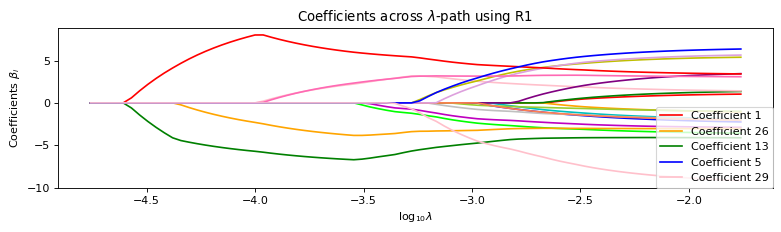

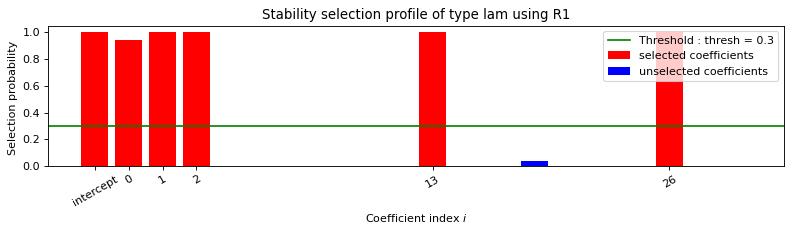

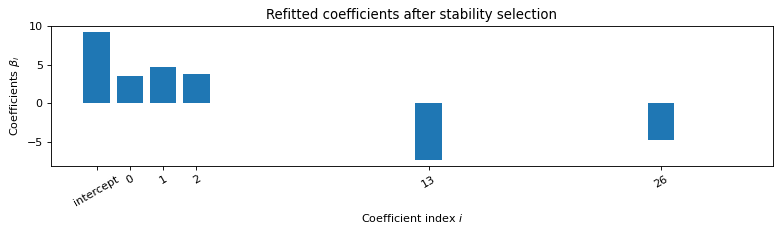


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.011s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.103s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.48  4.72  3.75  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.26  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.69  0.    0.    0.  ]
Error: 3297.49

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


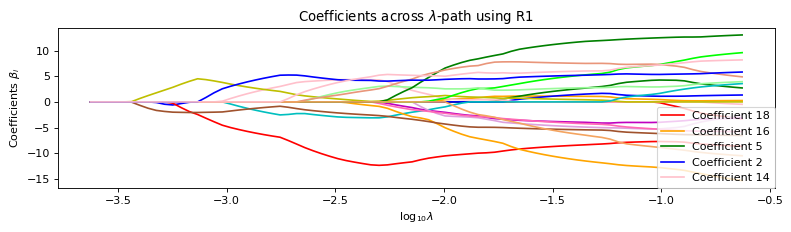

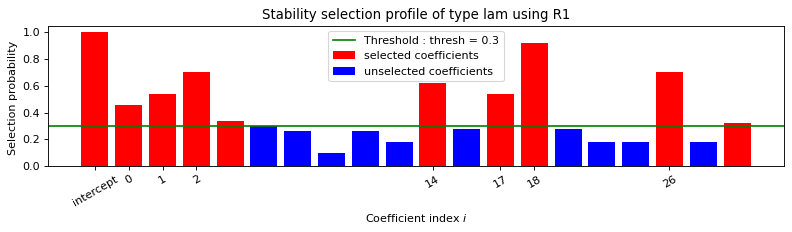

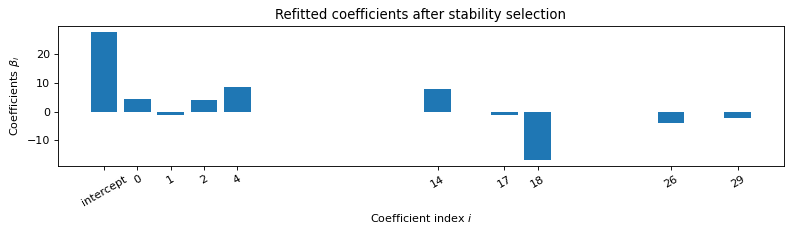


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    4    14    17    18    26    29    
   Running time :  0.24s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  4.52  -1.1    4.     0.     8.51   0.     0.     0.     0.     0.
   0.     0.     0.     0.     8.06   0.     0.    -1.08 -16.75   0.
   0.     0.     0.     0.     0.     0.    -3.96   0.     0.    -2.2 ]
Error: 2480.77

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


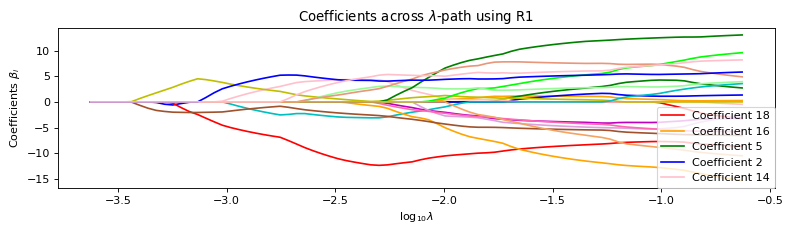

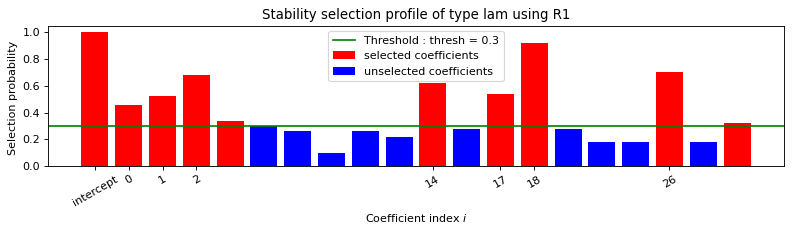

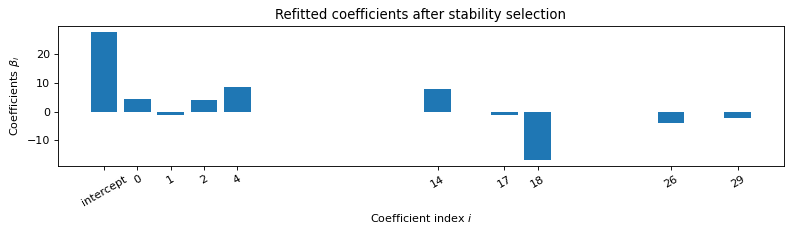

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    4    14    17    18    26    29    
   Running time :  0.119s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.97 -1.87  2.14 -5.95  2.91  2.46  2.13  1.88  1.68  1.52  1.39  1.28
  1.18 -6.69  1.55  1.45  2.42 17.54  0.32  0.3   0.29  0.27  0.26  0.25
  0.24  4.11  0.08  0.08  2.24]
Error: 2480.77

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.29853286]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99570342]...
INFO:absl:Predict treatment effect...


Error: 859.48

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3341.43

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3458.35

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -4.664
Model:                         IV2SLS   Adj. R-squared:                 -5.014
Method:                     Two Stage   F-statistic:                   0.02781
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:44:36                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.3143        nan        nan        n

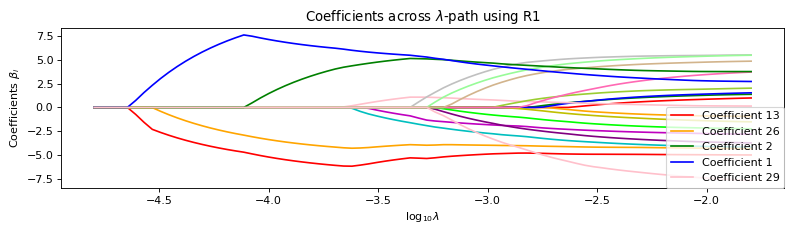

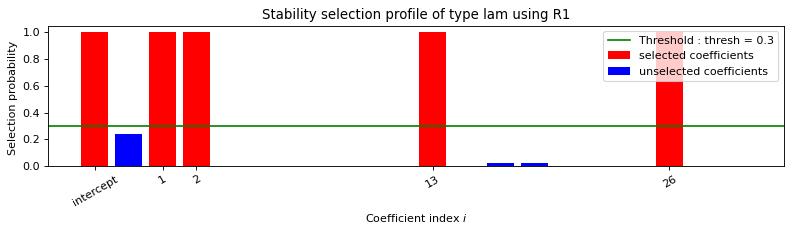

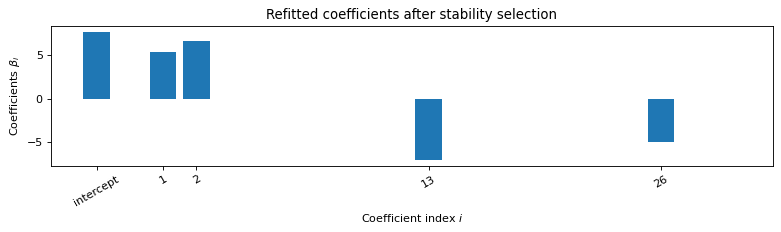


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.01s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.096s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.34  6.6   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.97  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.97  0.    0.    0.  ]
Error: 3285.38

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


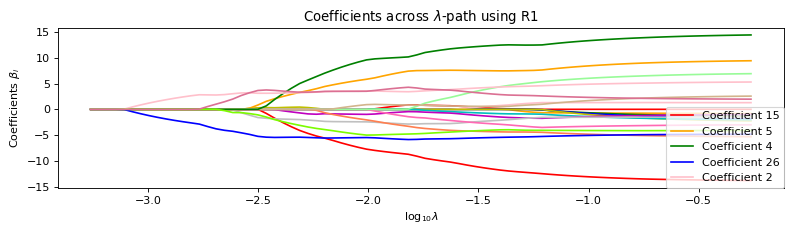

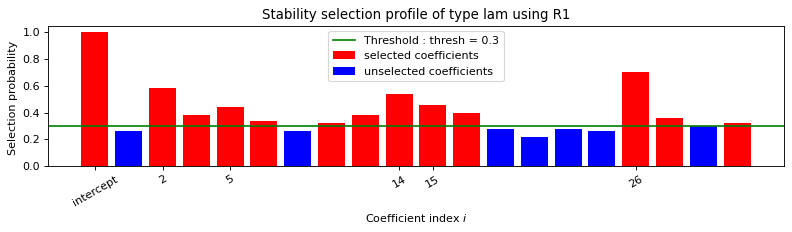

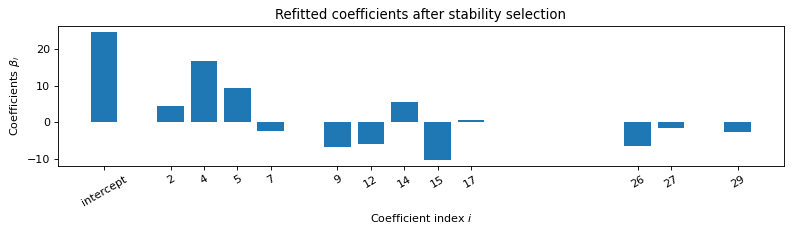


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    4    5    7    9    12    14    15    17    26    27    29    
   Running time :  0.473s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     0.     4.46   0.    16.68   9.32   0.    -2.45   0.    -6.78
   0.     0.    -6.1    0.     5.48 -10.29   0.     0.62   0.     0.
   0.     0.     0.     0.     0.     0.    -6.45  -1.7    0.    -2.8 ]
Error: 1929.57

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


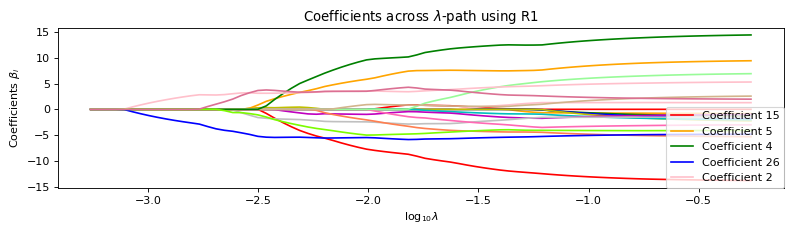

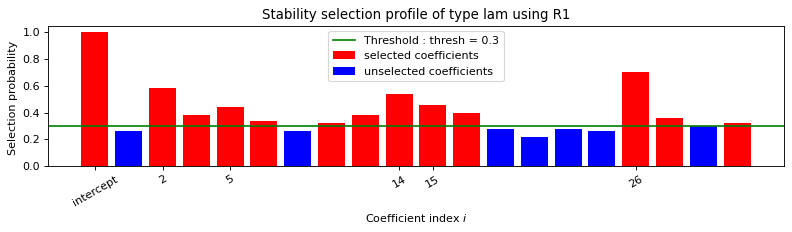

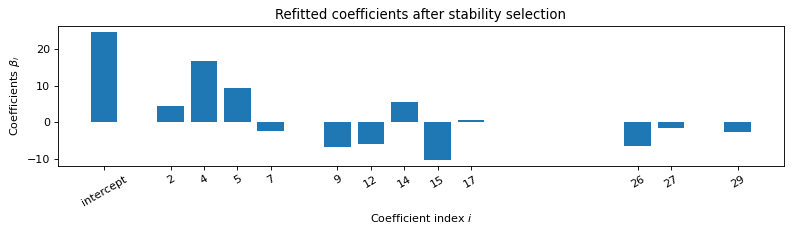

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.005s

 STABILITY SELECTION : 
   Selected variables :  intercept    2    4    5    7    9    12    14    15    17    26    27    29    
   Running time :  0.135s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.000e+00 -3.640e+00  1.290e+00 -1.392e+01 -4.650e+00  4.700e+00
  6.360e+00  3.300e+00  9.380e+00  2.020e+00  1.850e+00  7.560e+00
  1.120e+00 -4.250e+00  1.130e+01  6.300e-01 -1.000e-02  5.900e-01
  5.600e-01  5.300e-01  5.100e-01  4.900e-01  4.700e-01  4.500e-01
  4.300e-01  6.740e+00  1.830e+00  1.000e-01  2.840e+00]
Error: 1929.57

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.26427186]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-1.98573227]...
INFO:absl:Predict treatment effect...


Error: 797.4

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3237.89

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2037.96

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -424.098
Model:                         IV2SLS   Adj. R-squared:               -450.328
Method:                     Two Stage   F-statistic:                 0.0009519
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:47:07                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -446.4753   2.31e+09  -1.93e-07      1.0

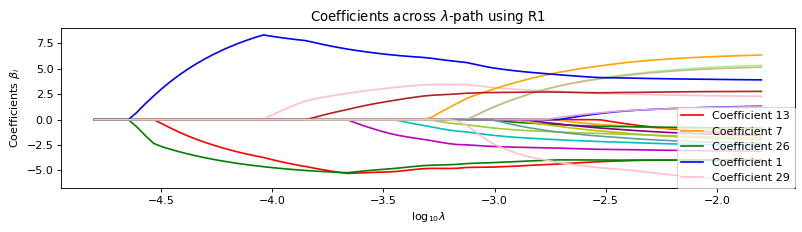

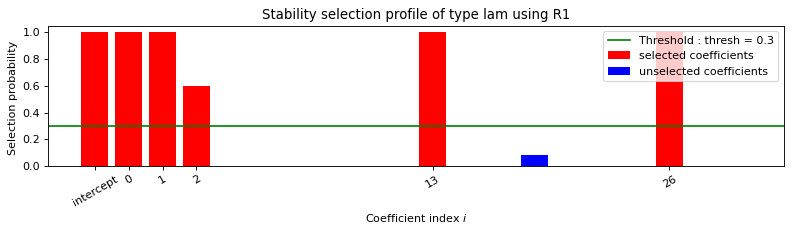

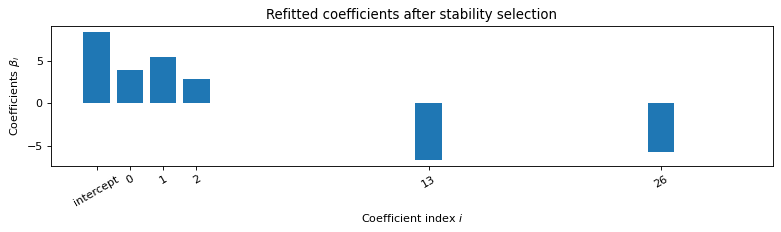


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.059s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 3.92  5.38  2.9   0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -6.57  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -5.63  0.    0.    0.  ]
Error: 3811.54

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


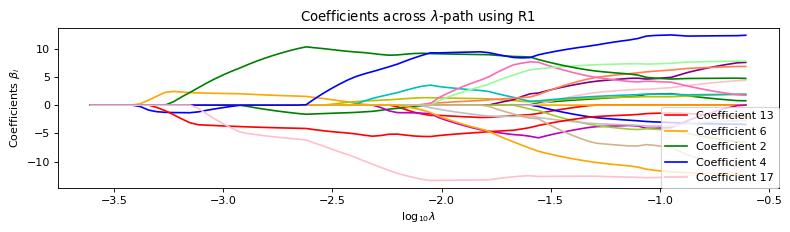

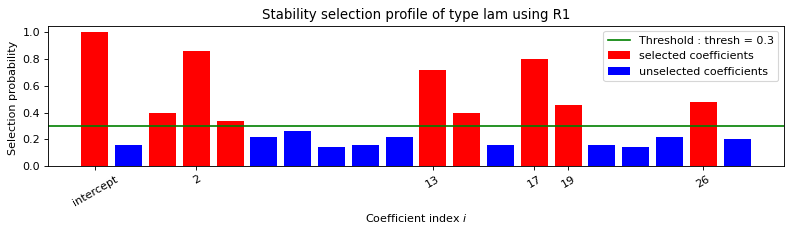

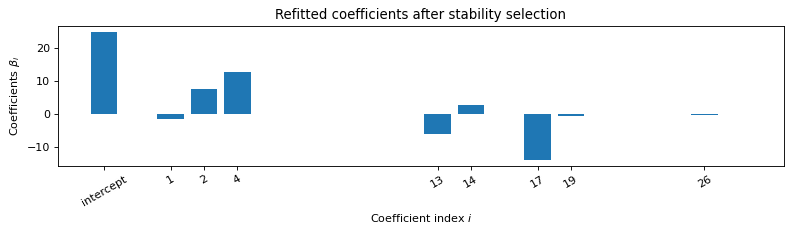


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    4    13    14    17    19    26    
   Running time :  0.094s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.    -1.51   7.59   0.    12.64   0.     0.     0.     0.     0.
   0.     0.     0.    -6.19   2.57   0.     0.   -13.99   0.    -0.76
   0.     0.     0.     0.     0.     0.    -0.36   0.     0.     0.  ]
Error: 2927.9

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


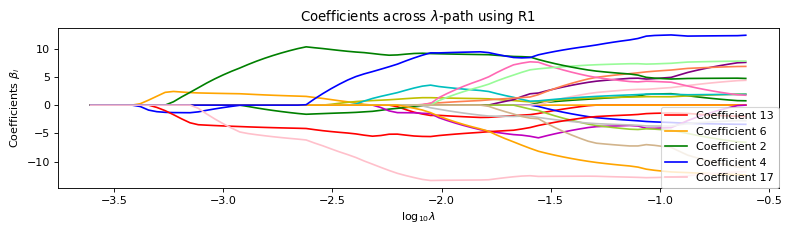

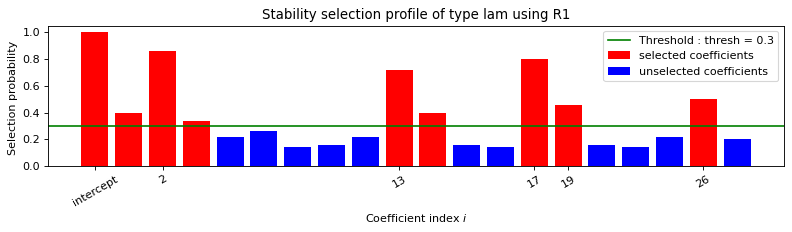

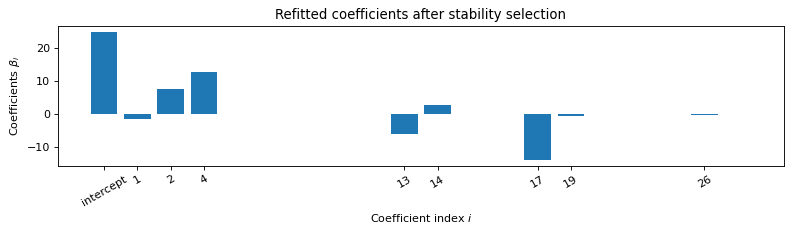

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    4    13    14    17    19    26    
   Running time :  0.102s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 1.070e+00 -6.810e+00  1.760e+00 -9.940e+00  3.420e+00  2.890e+00
  2.500e+00  2.210e+00  1.970e+00  1.790e+00  1.630e+00  1.500e+00
  7.360e+00 -1.620e+00  9.700e-01  9.200e-01  1.446e+01  6.000e-02
  8.000e-01  2.000e-02  2.000e-02  2.000e-02  2.000e-02  1.000e-02
  1.000e-02  3.600e-01  0.000e+00  0.000e+00  0.000e+00]
Error: 2927.9

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.48970389]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99573227]...
INFO:absl:Predict treatment effect...


Error: 937.47

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3804.12

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 4608.63

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                    -773.237
Model:                         IV2SLS   Adj. R-squared:               -821.009
Method:                     Two Stage   F-statistic:                 3.744e-05
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:48:57                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        488.5925   2.22e+10    2.2e-08      1.0

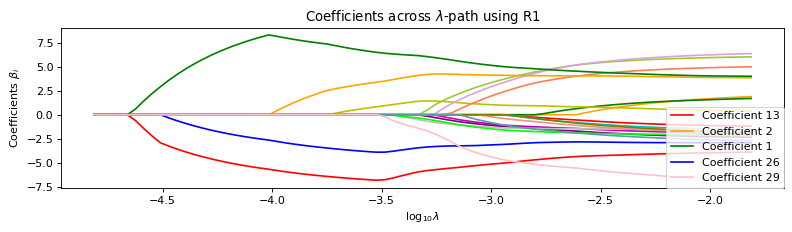

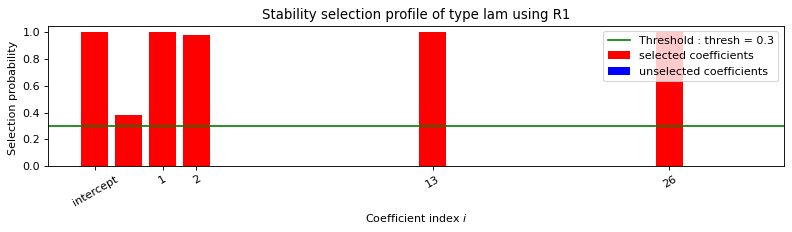

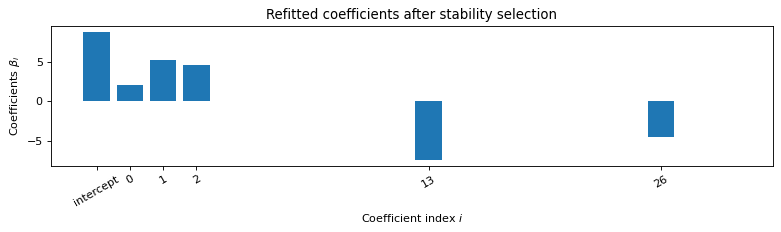


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.006s

 STABILITY SELECTION : 
   Selected variables :  intercept    0    1    2    13    26    
   Running time :  0.052s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 2.08  5.23  4.65  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.41  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.55  0.    0.    0.  ]
Error: 3362.99

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


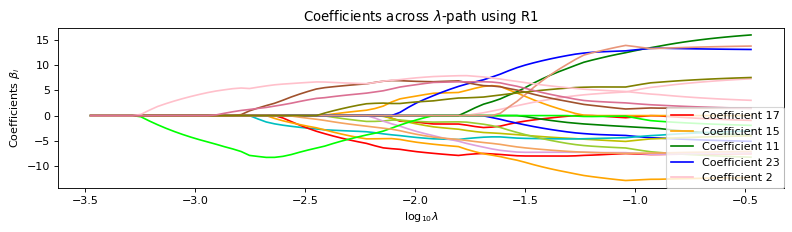

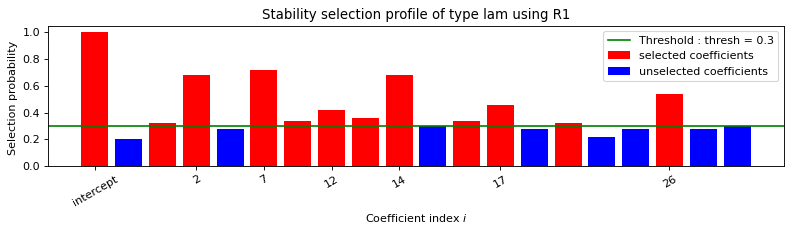

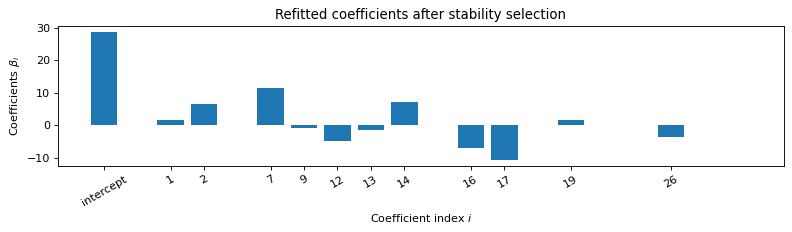


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.007s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    12    13    14    16    17    19    26    
   Running time :  0.118s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     1.49   6.42   0.     0.     0.     0.    11.41   0.    -0.86
   0.     0.    -4.75  -1.49   7.21   0.    -7.11 -10.54   0.     1.77
   0.     0.     0.     0.     0.     0.    -3.55   0.     0.     0.  ]
Error: 2851.79

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


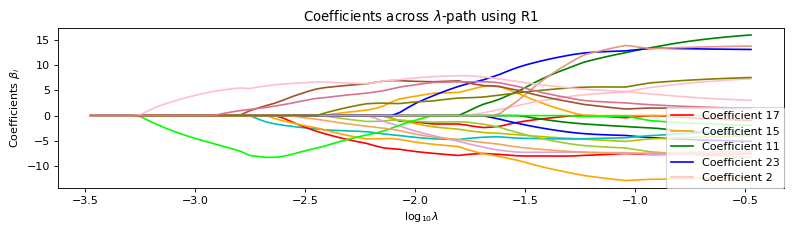

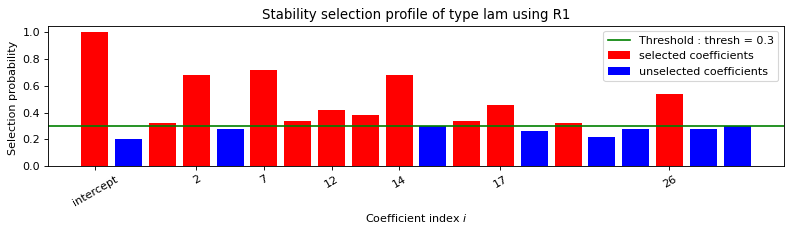

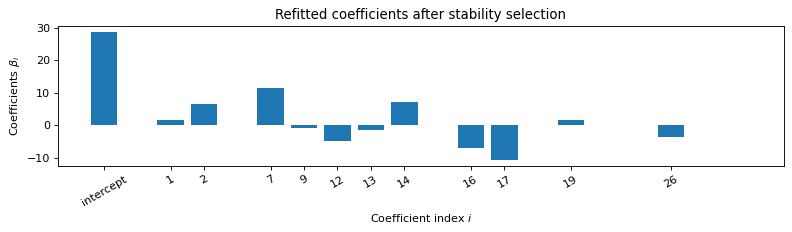

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    7    9    12    13    14    16    17    19    26    
   Running time :  0.117s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [-1.06 -4.63  2.28  1.77  1.44  1.22 -9.62  2.28  2.86  1.76  1.61  6.04
  2.46 -6.13  1.25  8.08 10.94  0.1  -1.63  0.17  0.17  0.16  0.15  0.15
  0.14  3.62  0.    0.    0.  ]
Error: 2851.79

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [1.91826687]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99572719]...
INFO:absl:Predict treatment effect...


Error: 878.11

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3370.14

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2519.45

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 11

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                     -53.530
Model:                         IV2SLS   Adj. R-squared:                -56.895
Method:                     Two Stage   F-statistic:                  -0.01029
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:50:40                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.8950   2.34e+08   4.77e-07      1.0

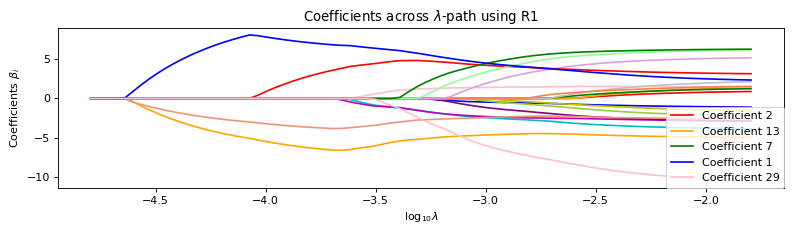

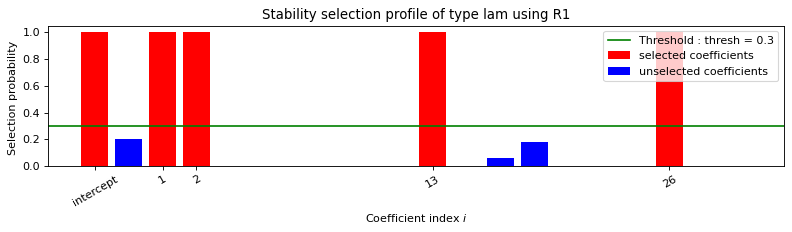

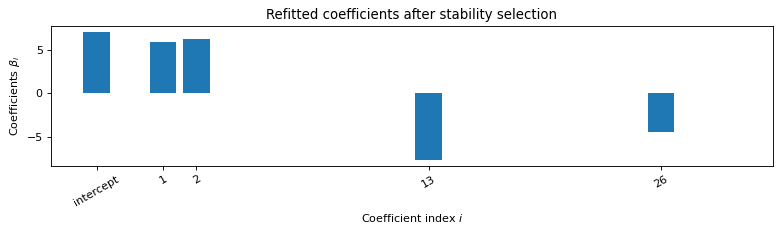


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    2    13    26    
   Running time :  0.067s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ 0.    5.83  6.25  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   -7.66  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.   -4.42  0.    0.    0.  ]
Error: 3983.09

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Dirichlet + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Dirichlet Regression not tried for performance reasons.
---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR + Log Contrast >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


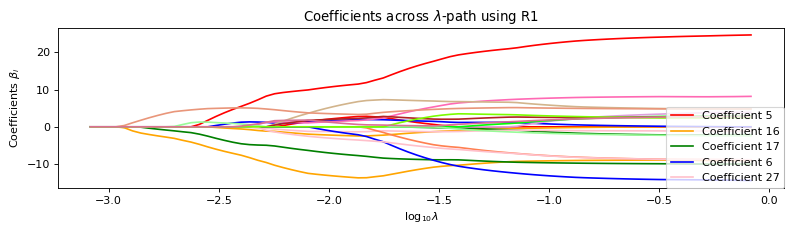

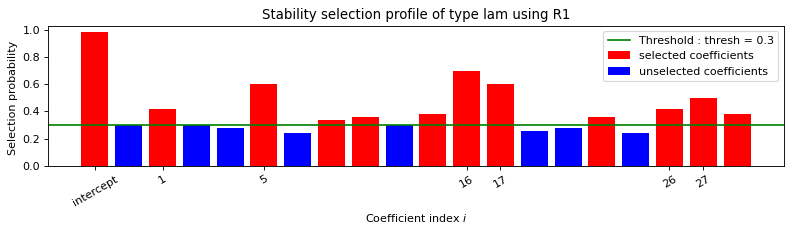

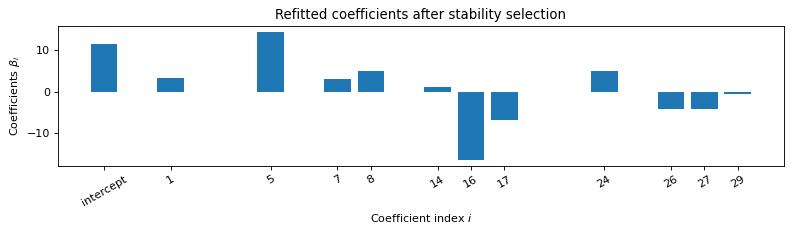


 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.009s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    5    7    8    14    16    17    24    26    27    29    
   Running time :  0.178s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [  0.     3.37   0.     0.     0.    14.32   0.     3.15   5.     0.
   0.     0.     0.     0.     1.13   0.   -16.34  -6.83   0.     0.
   0.     0.     0.     0.     5.05   0.    -4.19  -4.11   0.    -0.55]
Error: 3625.89

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< ALR MODEL>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


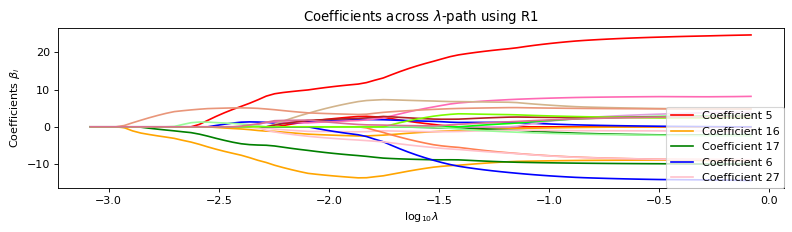

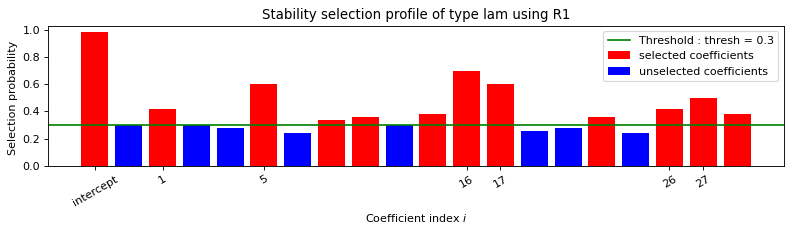

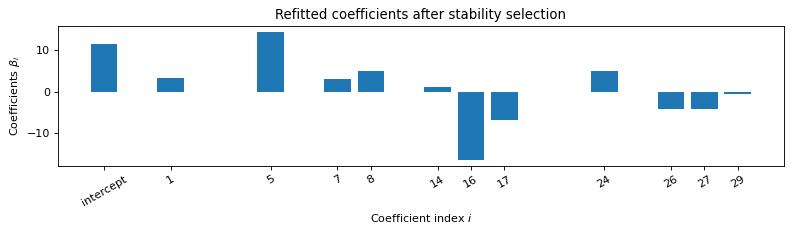

INFO:absl:Setup matrices...



 PATH COMPUTATION : 
 There is also an intercept.  
   Running time :  0.008s

 STABILITY SELECTION : 
   Selected variables :  intercept    1    5    7    8    14    16    17    24    26    27    29    
   Running time :  0.152s

True Beta: [-5. -5. -5. -5.  5.  5.  5.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Estimated Beta: [ -2.38   1.38   0.97   0.75 -12.46   2.73  -0.59  -2.26   2.72   2.46
   2.25   2.07   1.92   0.69   1.74  17.49   7.25   0.21   0.19   0.19
   0.18   0.17   0.16  -4.79   0.35   4.44   4.21   0.02   0.56]
Error: 3625.89

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


INFO:absl:Optimize lambda...
INFO:absl:Optimal lambda [2.02520183]...
INFO:absl:Optimize xi...
INFO:absl:KIV2 minimization did not succeed.
INFO:absl:Optimal xi [-2.99572081]...
INFO:absl:Predict treatment effect...


Error: 998.78

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< ONLY SECOND STAGE - Kernel Regression KIV >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 3947.59

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - Kernel Regression KIV (manual) >>>>>>>>>>>>>>>>>>>>>>>>>
Error: 2967.55

---------------------------------------------------------------------------------------------
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 2SLS - ILR ILR Regression Implementation >>>>>>>>>>>>>>>>>>>>>>>


/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 29, but rank is 9

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1787: RuntimeWarning:

invalid value encountered in sqrt



                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                      -4.141
Model:                         IV2SLS   Adj. R-squared:                 -4.459
Method:                     Two Stage   F-statistic:                   0.06622
                        Least Squares   Prob (F-statistic):               1.00
Date:                 Mi, 14 Jul 2021                                         
Time:                        11:52:28                                         
No. Observations:                 500                                         
Df Residuals:                     470                                         
Df Model:                          29                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.9488        nan        nan        n

In [36]:
today = datetime.now()


is_negbinom = (param.strRel == "negbinom")
num_iteration = 20 if is_negbinom else 50
is_nonlinear = (param.strRel == "nonlinear")

df_beta, df_mse, mse_large_confidence= run_methods_confidence_interval(
    param.key, num_iteration, 
    param.n, param.p, param.num_inst, param.mu_c, param.c_X, 
    param.alpha0, param.alphaT, param.c_Y, param.beta0, param.betaT, 
    is_nonlinear=is_nonlinear, is_negbinom=is_negbinom,
    num_star=250)

## Save results

For convenience and runtime purpose, we save the data in the temp folder.

In [37]:
import pickle
results = {
    "df_mse": df_mse,
    "df_beta": df_beta,
    "mse_large": mse_large_confidence
}

with open(os.path.join(os.getcwd(),"temp", "results.pickle"), "wb") as f:
    pickle.dump(results, f)
    f.close()


In [38]:
with open(os.path.join(os.getcwd(),"temp", "results.pickle"), "rb") as f:
    results = pickle.load(f)
    df_mse = results["df_mse"]
    df_beta = results["df_beta"]
    f.close()

# Generation of final plots

## Out of sample MSE plots

In [46]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR"]
fig = plot_mse_results(df_mse, filter_list)

# depending on outliers in the ILR+ILR method, you can update the axes ranges here
fig.update_yaxes(range=(0, 100000))
fig.show()

In [47]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC"]

fig = plot_mse_results(df_mse, filter_list)
# depending on outliers in the ILR+ILR method, you can update the axes ranges here
fig.update_yaxes(range=(0, 100000))
fig.show()

In [48]:
filter_list = ["ALR+LC", "DIR+LC", "ONLY Second LC"]

fig = plot_mse_results(df_mse, filter_list, sort_to_filter=True)
fig.show()

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## True $\beta$ vs. estimated $\beta$s.

### Influential $\beta$ values

In [50]:
filter_list = ["ALR+LC", "DIR+LC", "ONLY Second LC"]
fig = plot_beta_results(df_beta, param.betaT, filter_list, sort_to_filter=True)
fig.update_layout(showlegend=False)
fig.show()

In [52]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR"]
fig = plot_beta_results(df_beta, param.betaT, filter_list, sort_to_filter=True)
fig.update_layout(showlegend=False)
fig.update_layout(width=2000, height=500)
fig.show()

### Non-influential $\beta$ values

In [53]:
filter_list = ["ALR+LC", "DIR+LC", "ONLY Second LC"]
fig = plot_beta_results(df_beta, param.betaT, filter_list, sort_to_filter=True, beta_zero=True)
fig.update_layout(showlegend=False)
fig.show()

/opt/anaconda3/envs/gen_iv_models/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
filter_list = ["ALR+LC", "ILR+LC", "ILR+ILR", "DIR+LC",  "ONLY Second LC", "ONLY Second ILR"]
fig = plot_beta_results(df_beta, param.betaT, filter_list, sort_to_filter=True, beta_zero=True)
fig.update_layout(showlegend=False)
fig.update_layout(width=2000, height=500)
fig.show()